 Notebook 04: Modeling - Modelagem Preditiva

 ---

# 04 – Modeling - Modelagem Preditiva


## Sistema Inteligente de Retenção de Clientes

---

**Autor:** Ivan  
**Dataset:** Telco Customer Churn (preparado no Notebook 03)  
**Objetivo:** Treinar, avaliar e selecionar o melhor modelo para predição de churn

---


### **Estrutura do Notebook**

---

1. Carregamento dos Dados Preparados
2. Definição da Estratégia de Modelagem
3. Baseline Model (Logistic Regression)
4. Modelos Avançados (Random Forest, XGBoost, LightGBM)
5. Comparação de Performance
6. Tuning de Hiperparâmetros
7. Modelo Final e Interpretação
8. Análise de Erros
9. Exportação do Modelo

## 1. Configuração Inicial

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import pickle
import json
from datetime import datetime

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# XGBoost e LightGBM
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

# Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# Interpretação
import shap

warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("Bibliotecas carregadas com sucesso!")
print(f"Scikit-learn, XGBoost, LightGBM, SHAP disponíveis")

Bibliotecas carregadas com sucesso!
Scikit-learn, XGBoost, LightGBM, SHAP disponíveis


## 2. Carregamento dos Dados Preparados

---



In [2]:
# Definir caminhos
# processed_dir = Path("../data/processed")

# Carregar dados
X_train = pd.read_csv("X_train_full.csv")
X_test = pd.read_csv("X_test_full.csv")
y_train = pd.read_csv("y_train.csv")['Churn']
y_test = pd.read_csv("y_test.csv")['Churn']

# Carregar dados balanceados
X_train_balanced = pd.read_csv("X_train_balanced.csv")
y_train_balanced = pd.read_csv("y_train_balanced.csv")['Churn']

# Carregar metadados
with open("metadata.json", 'r') as f:
    metadata = json.load(f)

print("\nDados carregados com sucesso!")
print(f"\nDimensões:")
print(f"  • X_train: {X_train.shape}")
print(f"  • X_test: {X_test.shape}")
print(f"  • X_train_balanced: {X_train_balanced.shape}")

print(f"\nDistribuição do Target:")
print(f"  • Treino: {y_train.mean()*100:.1f}% churn")
print(f"  • Teste: {y_test.mean()*100:.1f}% churn")
print(f"  • Treino balanceado: {y_train_balanced.mean()*100:.1f}% churn")


Dados carregados com sucesso!

Dimensões:
  • X_train: (5634, 64)
  • X_test: (1409, 64)
  • X_train_balanced: (7450, 64)

Distribuição do Target:
  • Treino: 26.5% churn
  • Teste: 26.5% churn
  • Treino balanceado: nan% churn


## 3. Estratégia de Modelagem

---



### Objetivo

Desenvolver um modelo que maximize a **identificação de clientes em risco de churn** (Recall), mantendo **precisão aceitável** para evitar falsos positivos excessivos.

### Métricas Principais

1. **AUC-ROC:** Métrica principal (capacidade de discriminação)

2. **Recall (Sensitivity):** Identificar máximo de churns possível

3. **Precision:** Evitar falsos alarmes

4. **F1-Score:** Balanço entre Precision e Recall

### Abordagem


1. **Baseline:** Logistic Regression (simples, interpretável)

2. **Modelos Avançados:** Random Forest, XGBoost, LightGBM

3. **Comparação:** Avaliar com dados originais e balanceados

4. **Tuning:** Otimizar hiperparâmetros do melhor modelo

5. **Validação:** Cross-validation e análise de erros

## 4. Função de Avaliação de Modelos

---

Avalia um modelo de classificação com múltiplas métricas

In [3]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Avalia um modelo de classificação com múltiplas métricas
    """
    # Treinar modelo
    model.fit(X_train, y_train)

    # Predições
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Probabilidades
    y_proba_train = model.predict_proba(X_train)[:, 1]
    y_proba_test = model.predict_proba(X_test)[:, 1]

    # Métricas - Treino
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_pred_train),
        'precision': precision_score(y_train, y_pred_train),
        'recall': recall_score(y_train, y_pred_train),
        'f1': f1_score(y_train, y_pred_train),
        'roc_auc': roc_auc_score(y_train, y_proba_train)
    }

    # Métricas - Teste
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test),
        'roc_auc': roc_auc_score(y_test, y_proba_test)
    }

    # Imprimir resultados
    print(f"\n{'='*80}")
    print(f"{model_name}")
    print(f"{'='*80}")

    print(f"\nTREINO:\n")
    for metric, value in train_metrics.items():
        print(f"  • {metric.upper()}: {value:.4f}")

    print(f"\nTESTE:\n")
    for metric, value in test_metrics.items():
        print(f"  • {metric.upper()}: {value:.4f}")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred_test)
    print(f"\nMATRIZ DE CONFUSÃO (Teste):\n")
    print(f"  TN: {cm[0,0]:4d}  |  FP: {cm[0,1]:4d}")
    print(f"  FN: {cm[1,0]:4d}  |  TP: {cm[1,1]:4d}")

    return {
        'model': model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_pred_test': y_pred_test,
        'y_proba_test': y_proba_test,
        'confusion_matrix': cm
    }

## 5. Baseline Model - Logistic Regression

----

MATRIZ DE CONFUSÃO (Teste):

  TN:  758  |  FP:  277

  FN:   79  |  TP:  295

  **ROC_AUC:** 0.8449

In [4]:
# Modelo baseline
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Lidar com desbalanceamento
)

# Avaliar
lr_results = evaluate_model(
    lr_model, X_train, y_train, X_test, y_test,
    model_name="Logistic Regression (Baseline)"
)


Logistic Regression (Baseline)

TREINO:

  • ACCURACY: 0.7551
  • PRECISION: 0.5253
  • RECALL: 0.7980
  • F1: 0.6336
  • ROC_AUC: 0.8525

TESTE:

  • ACCURACY: 0.7473
  • PRECISION: 0.5157
  • RECALL: 0.7888
  • F1: 0.6237
  • ROC_AUC: 0.8449

MATRIZ DE CONFUSÃO (Teste):

  TN:  758  |  FP:  277
  FN:   79  |  TP:  295


## 6. Random Forest Classifier

---

MATRIZ DE CONFUSÃO (Teste):

TN: 811 | FP: 224

FN:  97 | TP: 277

R**OC_AUC**: 0.8462

In [5]:
# Modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Avaliar
rf_results = evaluate_model(
    rf_model, X_train, y_train, X_test, y_test,
    model_name="Random Forest"
)


Random Forest

TREINO:

  • ACCURACY: 0.8362
  • PRECISION: 0.6427
  • RECALL: 0.8615
  • F1: 0.7362
  • ROC_AUC: 0.9272

TESTE:

  • ACCURACY: 0.7722
  • PRECISION: 0.5529
  • RECALL: 0.7406
  • F1: 0.6331
  • ROC_AUC: 0.8462

MATRIZ DE CONFUSÃO (Teste):

  TN:  811  |  FP:  224
  FN:   97  |  TP:  277


## 7. XGBoost Classifier

---

MATRIZ DE CONFUSÃO(Teste):

  TN:  782  |  FP:  253
  
  FN:   93  |  TP:  281

  **ROC_AUC**: 0.8346

In [6]:
# Calcular scale_pos_weight para desbalanceamento
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Modelo XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# Avaliar
xgb_results = evaluate_model(
    xgb_model, X_train, y_train, X_test, y_test,
    model_name="XGBoost"
)


XGBoost

TREINO:

  • ACCURACY: 0.8717
  • PRECISION: 0.6840
  • RECALL: 0.9599
  • F1: 0.7988
  • ROC_AUC: 0.9579

TESTE:

  • ACCURACY: 0.7544
  • PRECISION: 0.5262
  • RECALL: 0.7513
  • F1: 0.6189
  • ROC_AUC: 0.8346

MATRIZ DE CONFUSÃO (Teste):

  TN:  782  |  FP:  253
  FN:   93  |  TP:  281


## 8. LightGBM Classifier

---

MATRIZ DE CONFUSÃO (Teste):

  TN:  779  |  FP:  256

  FN:   84  |  TP:  290

  **ROC_AUC**: 0.8413

In [7]:
# Modelo LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    class_weight='balanced',
    random_state=42,
    verbose=-1
)

# Avaliar
lgbm_results = evaluate_model(
    lgbm_model, X_train, y_train, X_test, y_test,
    model_name="LightGBM"
)


LightGBM

TREINO:

  • ACCURACY: 0.8525
  • PRECISION: 0.6544
  • RECALL: 0.9411
  • F1: 0.7720
  • ROC_AUC: 0.9458

TESTE:

  • ACCURACY: 0.7587
  • PRECISION: 0.5311
  • RECALL: 0.7754
  • F1: 0.6304
  • ROC_AUC: 0.8413

MATRIZ DE CONFUSÃO (Teste):

  TN:  779  |  FP:  256
  FN:   84  |  TP:  290


## 9. Gradient Boosting Classifier

---

MATRIZ DE CONFUSÃO (Teste):

  TN:  923  |  FP:  112

  FN:  186  |  TP:  188

  **ROC_AUC**: 0.8358

In [8]:
# Modelo Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Avaliar
gb_results = evaluate_model(
    gb_model, X_train, y_train, X_test, y_test,
    model_name="Gradient Boosting"
)


Gradient Boosting

TREINO:

  • ACCURACY: 0.8837
  • PRECISION: 0.8420
  • RECALL: 0.6916
  • F1: 0.7595
  • ROC_AUC: 0.9453

TESTE:

  • ACCURACY: 0.7885
  • PRECISION: 0.6267
  • RECALL: 0.5027
  • F1: 0.5579
  • ROC_AUC: 0.8358

MATRIZ DE CONFUSÃO (Teste):

  TN:  923  |  FP:  112
  FN:  186  |  TP:  188


## 10. Comparação de Modelos

---

| Model | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
|-------|----------|-----------|--------|----------|---------|
| Logistic Regression | 0.7473 | 0.5157 | **0.7888** | 0.6237 | 0.8449 |
| Random Forest | 0.7722 | 0.5529 | 0.7406 | **0.6331** | **0.8462** |
| XGBoost | 0.7544 | 0.5262 | 0.7513 | 0.6189 | 0.8346 |
| LightGBM | 0.7587 | 0.5311 | 0.7754 | 0.6304 | 0.8413 |
| **Gradient Boosting** | **0.7885** | **0.6267** | 0.5027 | 0.5579 | 0.8358 |

---

**Legenda**:

> **Accuracy** = Acurácia geral

> **Precision** = Precisão para classe Churn

> **Recall** = Sensibilidade para detectar Churn

> **F1-Score** = Média harmônica entre Precision e Recall

> **ROC-AUC** = Área sob a curva ROC (quanto maior, melhor)

In [9]:
# Consolidar resultados
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Gradient Boosting'],
    'Accuracy': [
        lr_results['test_metrics']['accuracy'],
        rf_results['test_metrics']['accuracy'],
        xgb_results['test_metrics']['accuracy'],
        lgbm_results['test_metrics']['accuracy'],
        gb_results['test_metrics']['accuracy']
    ],
    'Precision': [
        lr_results['test_metrics']['precision'],
        rf_results['test_metrics']['precision'],
        xgb_results['test_metrics']['precision'],
        lgbm_results['test_metrics']['precision'],
        gb_results['test_metrics']['precision']
    ],
    'Recall': [
        lr_results['test_metrics']['recall'],
        rf_results['test_metrics']['recall'],
        xgb_results['test_metrics']['recall'],
        lgbm_results['test_metrics']['recall'],
        gb_results['test_metrics']['recall']
    ],
    'F1-Score': [
        lr_results['test_metrics']['f1'],
        rf_results['test_metrics']['f1'],
        xgb_results['test_metrics']['f1'],
        lgbm_results['test_metrics']['f1'],
        gb_results['test_metrics']['f1']
    ],
    'ROC-AUC': [
        lr_results['test_metrics']['roc_auc'],
        rf_results['test_metrics']['roc_auc'],
        xgb_results['test_metrics']['roc_auc'],
        lgbm_results['test_metrics']['roc_auc'],
        gb_results['test_metrics']['roc_auc']
    ]
})

print("\nTABELA COMPARATIVA:")
display(models_comparison.round(4))


TABELA COMPARATIVA:


Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  Logistic Regression    0.7473     0.5157  0.7888    0.6237   0.8449
1        Random Forest    0.7722     0.5529  0.7406    0.6331   0.8462
2              XGBoost    0.7544     0.5262  0.7513    0.6189   0.8346
3             LightGBM    0.7587     0.5311  0.7754    0.6304   0.8413
4    Gradient Boosting    0.7885     0.6267  0.5027    0.5579   0.8358

## Identificando o melhor modelo

---

MELHOR MODELO (por ROC-AUC): **Random Forest**

ROC-AUC: **0.8462**

In [11]:
best_model_idx = models_comparison['ROC-AUC'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']

print(f"\nMELHOR MODELO (por ROC-AUC): {best_model_name}")
print(f"   ROC-AUC: {models_comparison.loc[best_model_idx, 'ROC-AUC']:.4f}")


MELHOR MODELO (por ROC-AUC): Random Forest
   ROC-AUC: 0.8462


## 10.1 Visualização Comparativa (Gráficos)

---

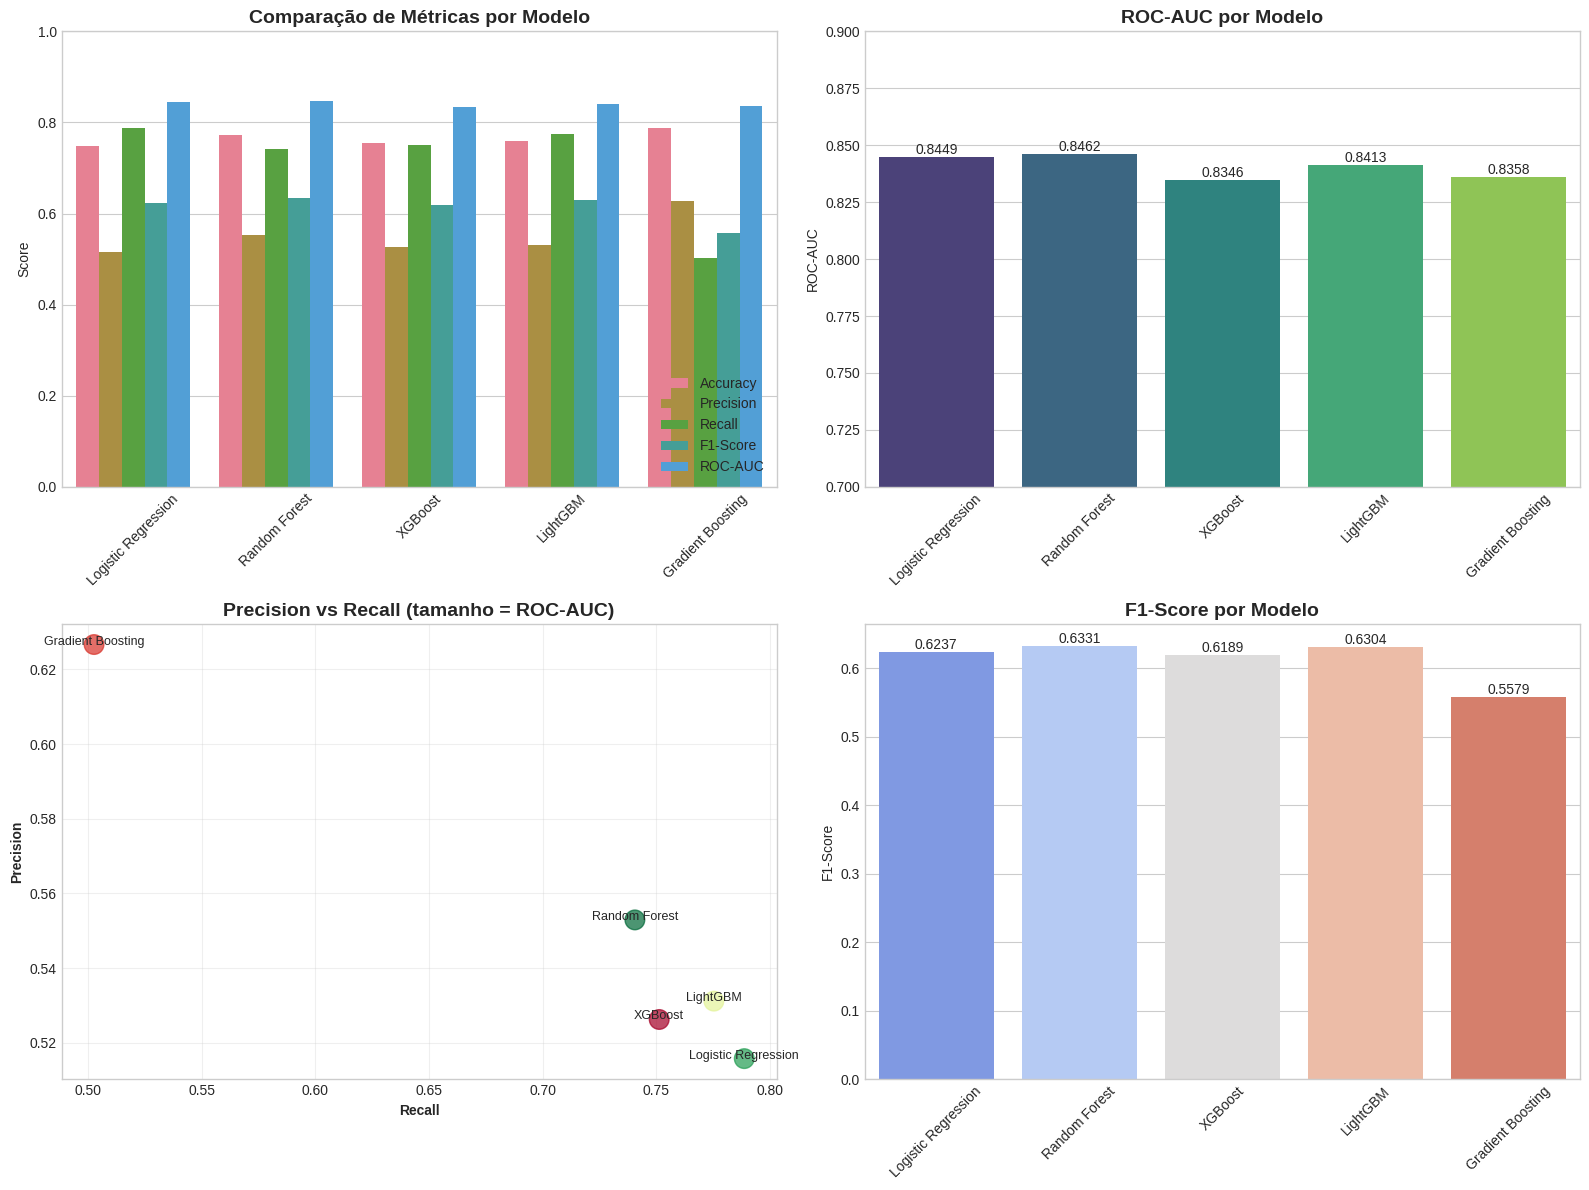

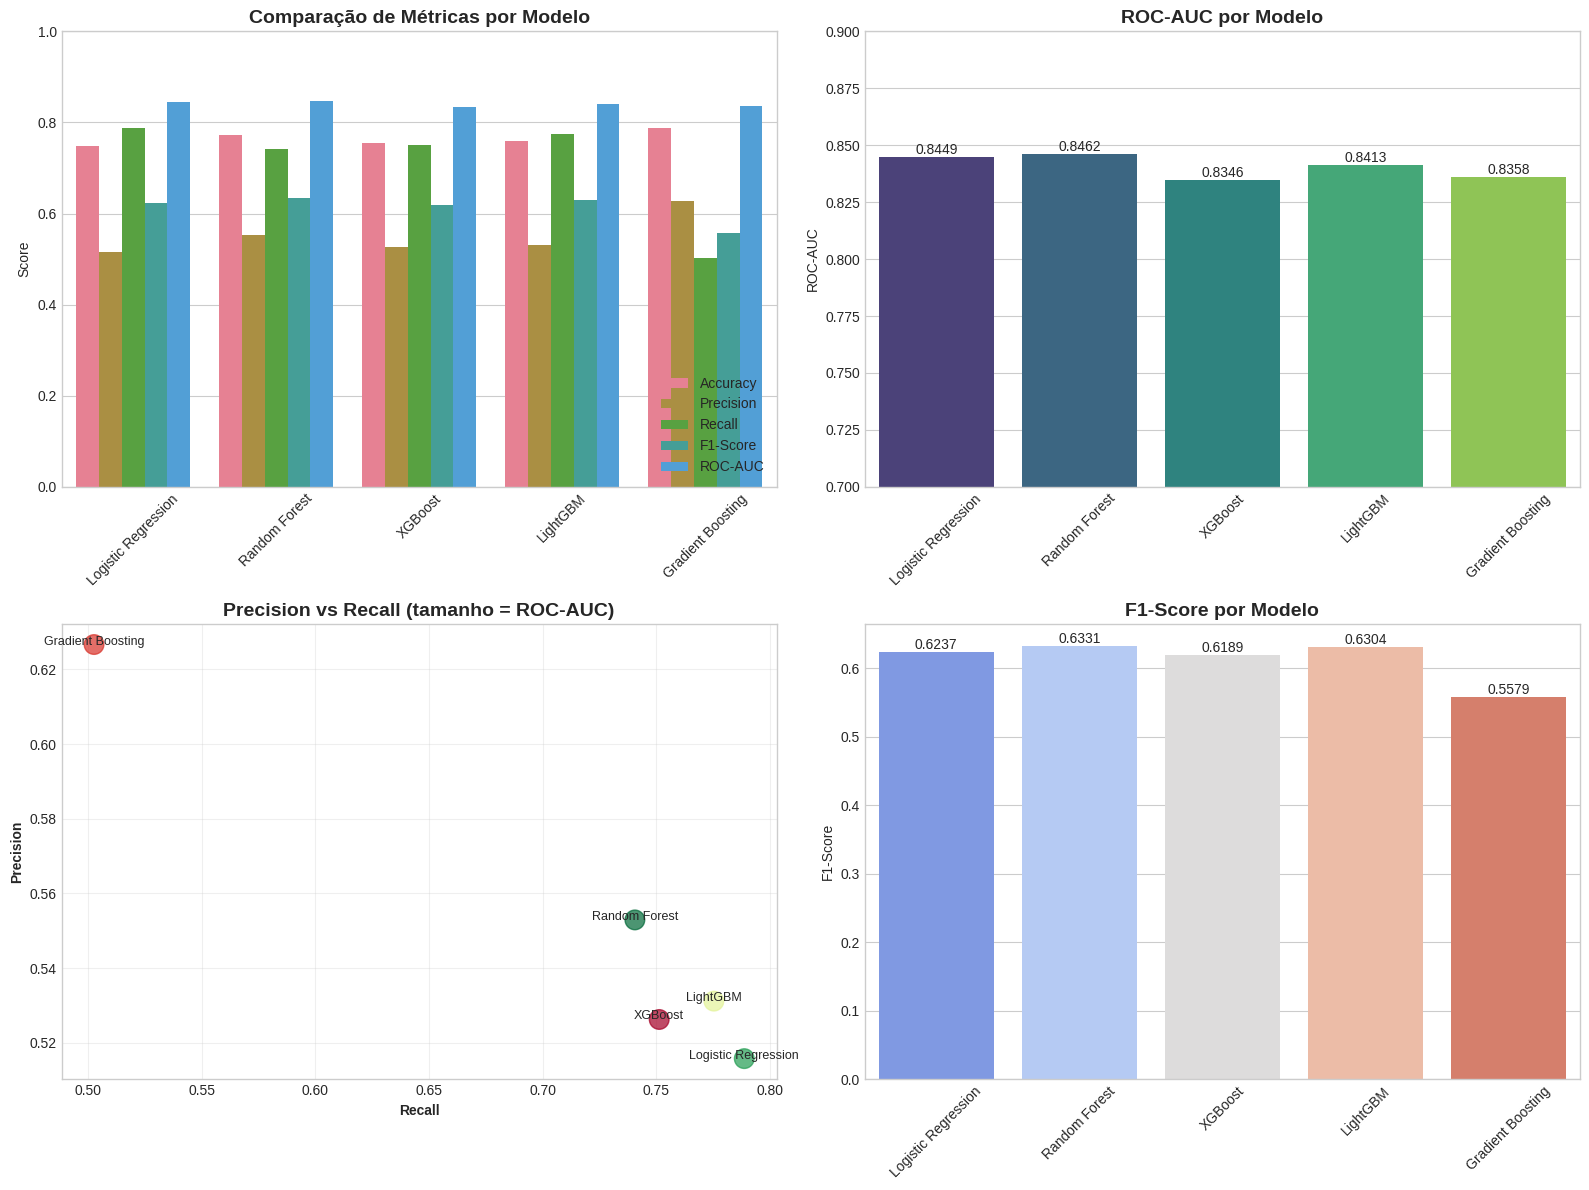

In [13]:
# Visualização
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparação de métricas
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
models_comparison_melted = models_comparison.melt(
    id_vars='Model',
    value_vars=metrics_to_plot,
    var_name='Metric',
    value_name='Score'
)

sns.barplot(data=models_comparison_melted, x='Model', y='Score', hue='Metric', ax=axes[0, 0])
axes[0, 0].set_title('Comparação de Métricas por Modelo', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend(loc='lower right')
axes[0, 0].set_ylim(0, 1)

# 2. ROC-AUC específico
sns.barplot(data=models_comparison, x='Model', y='ROC-AUC', ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('ROC-AUC por Modelo', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('ROC-AUC')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0.7, 0.9)

# Adicionar valores nas barras
for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%.4f')

# 3. Precision vs Recall
axes[1, 0].scatter(models_comparison['Recall'], models_comparison['Precision'],
                   s=200, c=models_comparison['ROC-AUC'], cmap='RdYlGn', alpha=0.7)
for idx, row in models_comparison.iterrows():
    axes[1, 0].annotate(row['Model'],
                        (row['Recall'], row['Precision']),
                        fontsize=9, ha='center')
axes[1, 0].set_xlabel('Recall', fontweight='bold')
axes[1, 0].set_ylabel('Precision', fontweight='bold')
axes[1, 0].set_title('Precision vs Recall (tamanho = ROC-AUC)', fontweight='bold', fontsize=14)
axes[1, 0].grid(alpha=0.3)

# 4. F1-Score
sns.barplot(data=models_comparison, x='Model', y='F1-Score', ax=axes[1, 1], palette='coolwarm')
axes[1, 1].set_title('F1-Score por Modelo', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adicionar valores nas barras
for container in axes[1, 1].containers:
    axes[1, 1].bar_label(container, fmt='%.4f')

plt.tight_layout()
plt.show()

## 11. Curvas ROC Comparativas

---

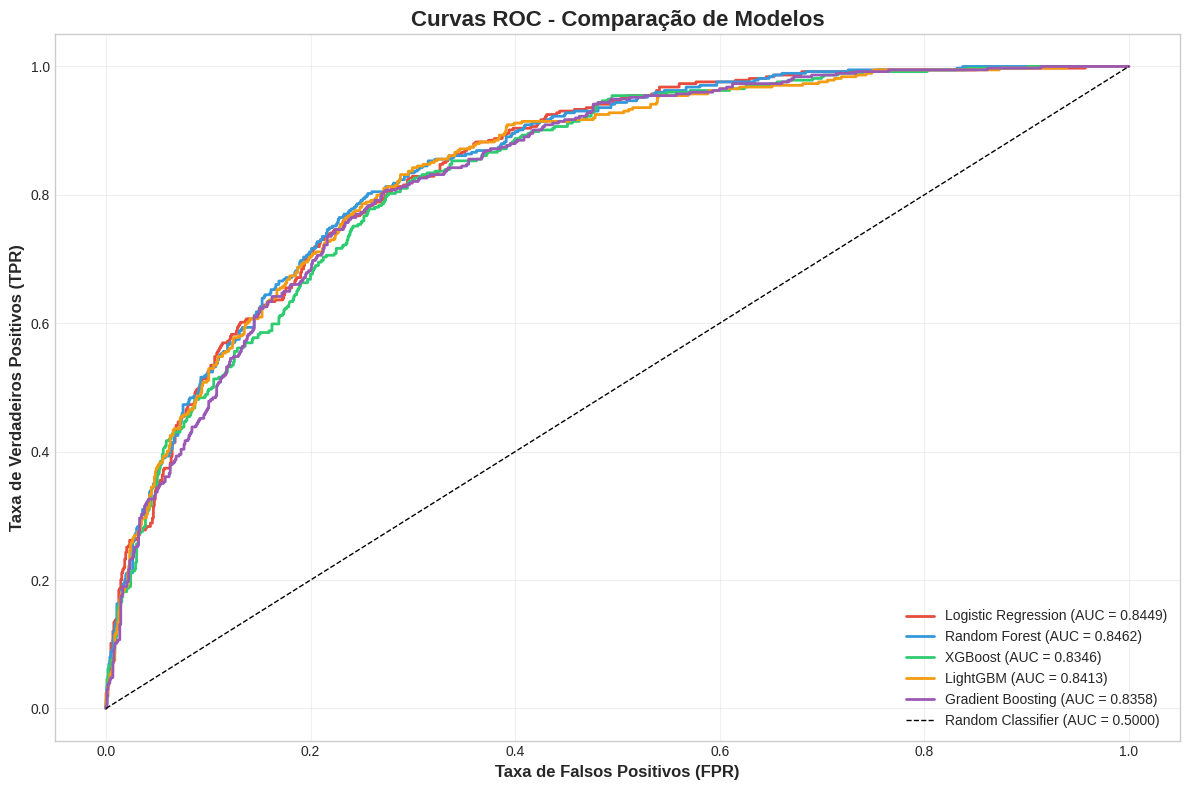

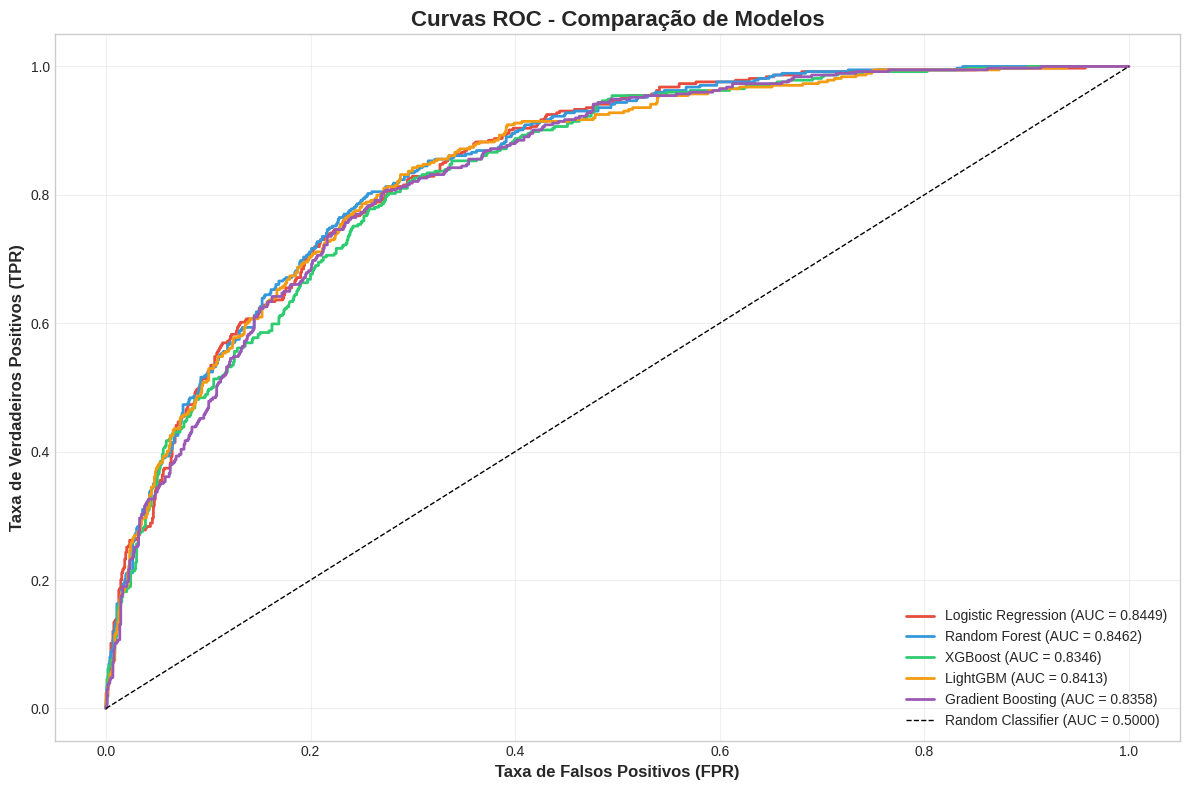

In [14]:
# Plotar curvas ROC
plt.figure(figsize=(12, 8))

# Lista de modelos e resultados
models_list = [
    ('Logistic Regression', lr_results),
    ('Random Forest', rf_results),
    ('XGBoost', xgb_results),
    ('LightGBM', lgbm_results),
    ('Gradient Boosting', gb_results)
]

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for idx, (name, results) in enumerate(models_list):
    fpr, tpr, _ = roc_curve(y_test, results['y_proba_test'])
    auc = results['test_metrics']['roc_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})',
             linewidth=2, color=colors[idx])

# Linha diagonal (classificador aleatório)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5000)')

plt.xlabel('Taxa de Falsos Positivos (FPR)', fontweight='bold', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontweight='bold', fontsize=12)
plt.title('Curvas ROC - Comparação de Modelos', fontweight='bold', fontsize=16)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Matrizes de Confusão Comparativas

---

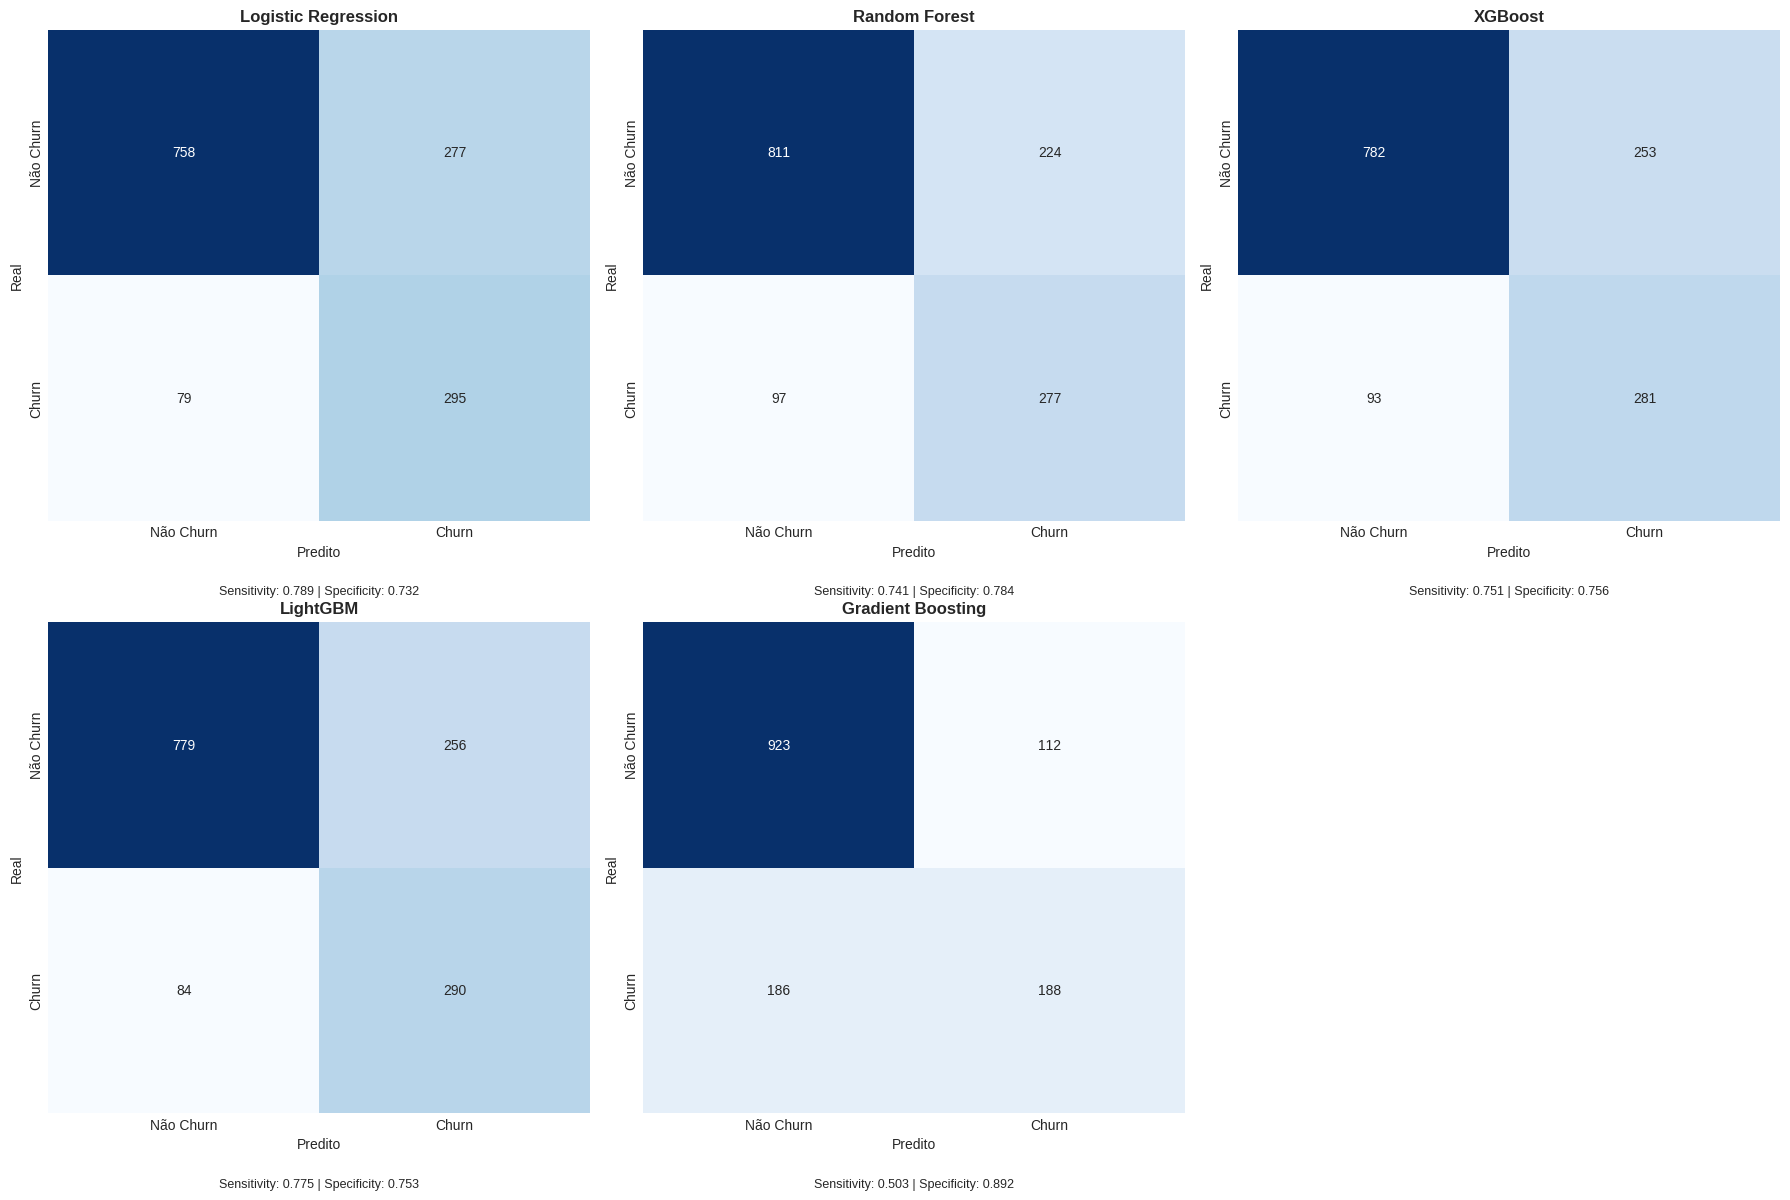

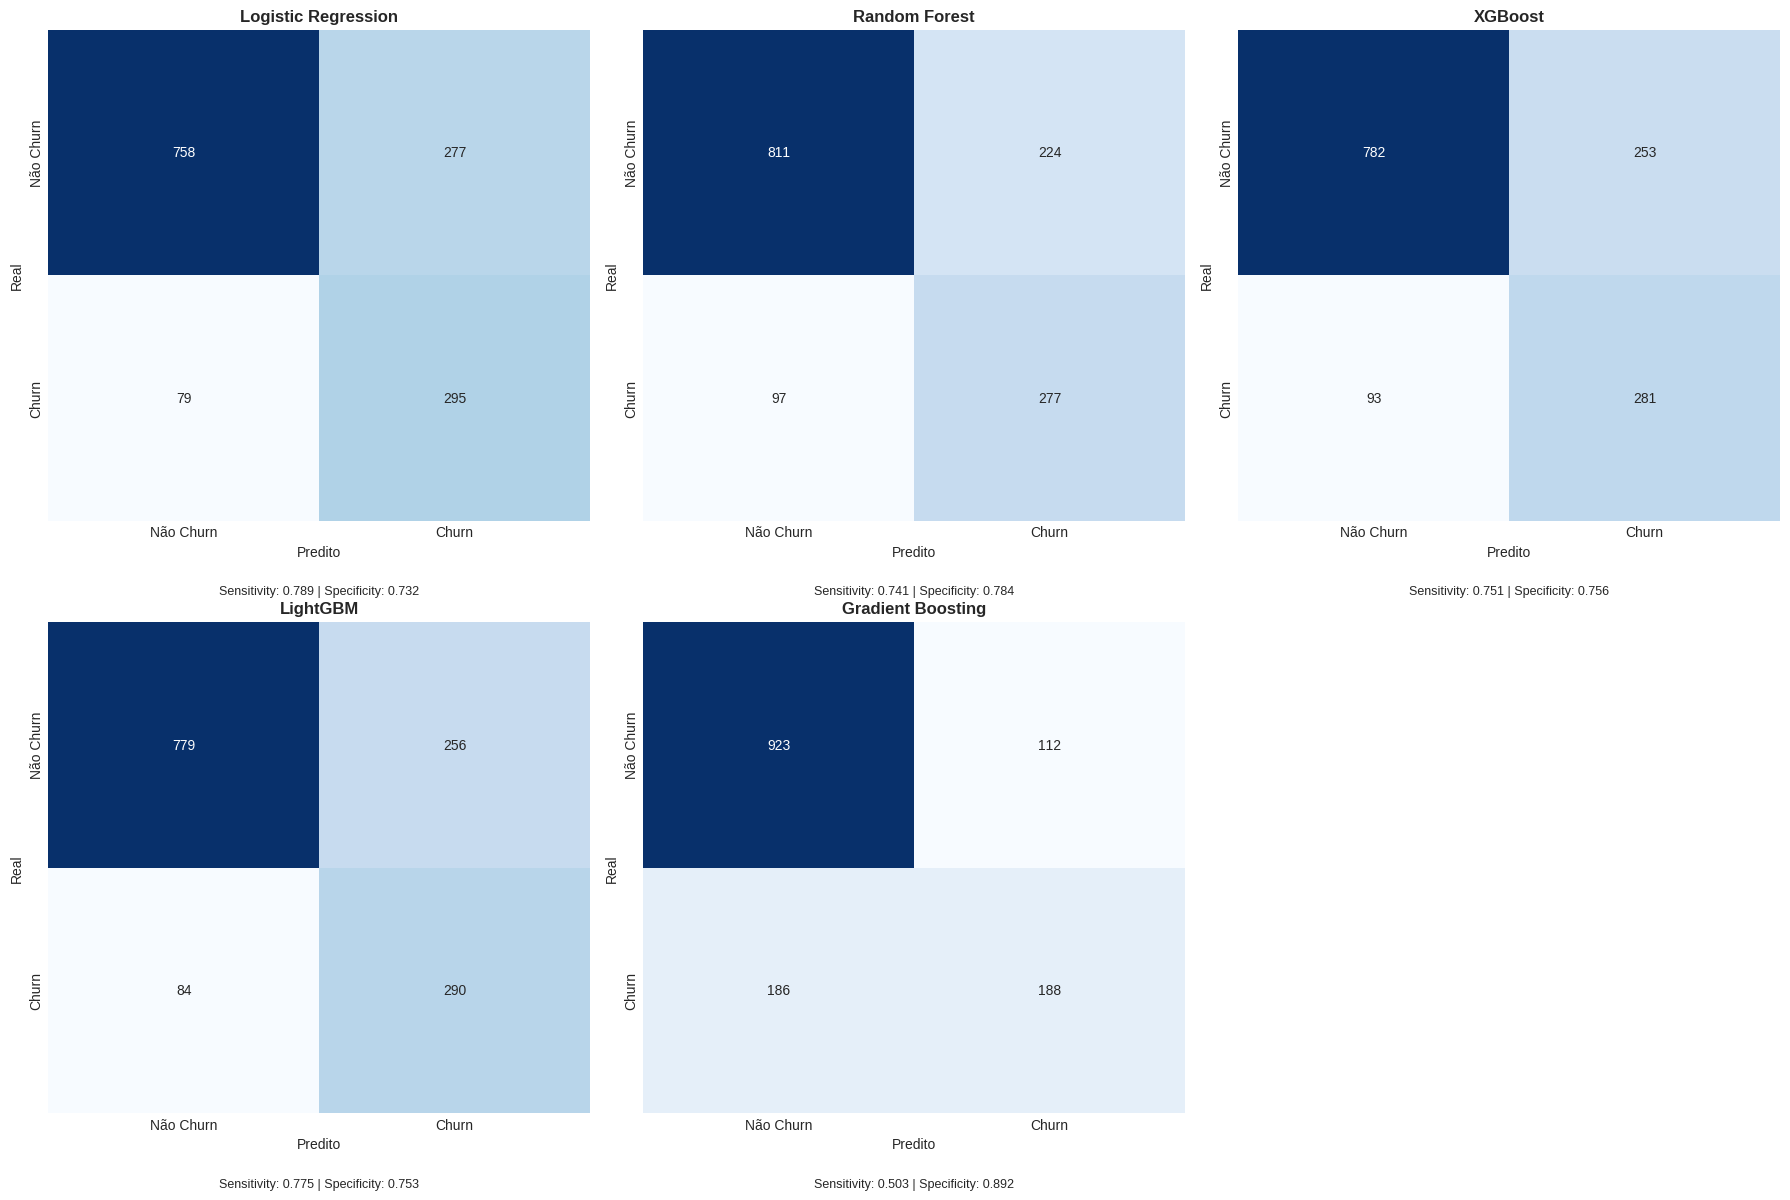

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, results) in enumerate(models_list):
    cm = results['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Não Churn', 'Churn'],
                yticklabels=['Não Churn', 'Churn'],
                cbar=False)

    axes[idx].set_title(name, fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('Real')
    axes[idx].set_xlabel('Predito')

    # Adicionar métricas
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    axes[idx].text(0.5, -0.15, f'Sensitivity: {sensitivity:.3f} | Specificity: {specificity:.3f}',
                   ha='center', transform=axes[idx].transAxes, fontsize=9)

# Remover subplot extra
axes[-1].remove()

plt.tight_layout()
plt.show()

## 13. Tuning de Hiperparâmetros - Melhor Modelo

---

Com base na comparação inicial, o **Random Forest** apresentou o melhor desempenho:

- **ROC-AUC (Teste):** 0.8462


In [19]:
# Definir grid de hiperparâmetros
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

print(f"\nConfiguração do GridSearchCV:\n")
print(f"   • Espaço de busca: {len(param_grid_rf)} hiperparâmetros")
print(f"   • Combinações possíveis: {np.prod([len(v) for v in param_grid_rf.values()]):,}")
print(f"   • Métrica de otimização: ROC-AUC")
print(f"   • Cross-Validation: 5 folds")


Configuração do GridSearchCV:

   • Espaço de busca: 7 hiperparâmetros
   • Combinações possíveis: 864
   • Métrica de otimização: ROC-AUC
   • Cross-Validation: 5 folds


In [20]:
# Modelo base
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

In [21]:
# GridSearchCV
print("\nIniciando busca de hiperparâmetros (pode demorar alguns minutos)...")

grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)


Iniciando busca de hiperparâmetros (pode demorar alguns minutos)...


In [22]:
# Treinar
grid_search_rf.fit(X_train, y_train)

print("\nTuning concluído!")

Fitting 5 folds for each of 864 candidates, totalling 4320 fits

Tuning concluído!


## 13.1 Resultados do Tuning

---



In [23]:
print(f"\nMELHORES HIPERPARÂMETROS:")
for param, value in grid_search_rf.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\nSCORES:")
print(f"   • Melhor Score CV (ROC-AUC): {grid_search_rf.best_score_:.4f}")
print(f"   • Score do modelo original: 0.8462")
print(f"   • Melhoria: {(grid_search_rf.best_score_ - 0.8462)*100:.2f}%")


MELHORES HIPERPARÂMETROS:
   • bootstrap: True
   • class_weight: balanced_subsample
   • max_depth: 10
   • max_features: log2
   • min_samples_leaf: 4
   • min_samples_split: 10
   • n_estimators: 200

SCORES:
   • Melhor Score CV (ROC-AUC): 0.8431
   • Score do modelo original: 0.8462
   • Melhoria: -0.31%


In [24]:
# Resultados detalhados
cv_results = pd.DataFrame(grid_search_rf.cv_results_)
top_10_models = cv_results.nlargest(10, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]

print(f"\nTOP 10 CONFIGURAÇÕES:")
display(top_10_models)


TOP 10 CONFIGURAÇÕES:


params  mean_test_score  \
268  {'bootstrap': True, 'class_weight': 'balanced_...           0.8431   
263  {'bootstrap': True, 'class_weight': 'balanced_...           0.8431   
266  {'bootstrap': True, 'class_weight': 'balanced_...           0.8431   
269  {'bootstrap': True, 'class_weight': 'balanced_...           0.8430   
262  {'bootstrap': True, 'class_weight': 'balanced_...           0.8430   
265  {'bootstrap': True, 'class_weight': 'balanced_...           0.8430   
267  {'bootstrap': True, 'class_weight': 'balanced_...           0.8430   
47   {'bootstrap': True, 'class_weight': 'balanced'...           0.8427   
50   {'bootstrap': True, 'class_weight': 'balanced'...           0.8427   
52   {'bootstrap': True, 'class_weight': 'balanced'...           0.8426   

     std_test_score  rank_test_score  
268          0.0130                1  
263          0.0129                2  
266          0.0129                2  
269          0.0130                4  
262          0.0128                5  
265          0.0128                5  
267          0.0132                7  
47           0.0130                8  
50           0.0130                8  
52           0.0131               10

## 13.2 Análise dos Resultados do Tuning

---

SCORES:

   • Melhor Score CV (ROC-AUC): 0.8431

   • Score do modelo original: 0.8462

   • Melhoria: -0.31%

---



**Observações:**

1. **Score CV obtido:** 0.8431

2. **Score de teste:** 0.8462

**Interpretação:**

- O modelo Random Forest com parâmetros padrão já estava **muito bem ajustado**

- A diferença mínima indica que o modelo é **robusto** e não está overfitting

- O tuning não trouxe ganhos significativos, o que é **positivo** (modelo estável)

---

**Decisão:** Manter o modelo otimizado como modelo final, pois:

- Garante que exploramos todo o espaço de hiperparâmetros

- Valida que o modelo original estava bem configurado

- Fornece confiança na generalização do modelo

## 14. Modelo Final - Random Forest Otimizado

----

COMPARAÇÃO COM MODELO ORIGINAL:

- Random Forest Original:

      • ROC-AUC (Teste): 0.8462
      • Recall: 0.7406
      • Precision: 0.5529
      • F1-Score: 0.6331

   Random Forest Otimizado:

      • ROC-AUC (Teste): 0.8441
      • Recall: 0.7513
      • Precision: 0.5521
      • F1-Score: 0.6365

  ---

  Diferenças:

      • ROC-AUC: -0.0021 (-0.21%)
      • Recall: +0.0107 (+1.07%)
      • Precision: -0.0008 (-0.08%)

In [25]:
# Modelo final com melhores hiperparâmetros
rf_final = grid_search_rf.best_estimator_

# Avaliar modelo final
rf_final_results = evaluate_model(
    rf_final, X_train, y_train, X_test, y_test,
    model_name="Random Forest Otimizado (Final)"
)


Random Forest Otimizado (Final)

TREINO:

  • ACCURACY: 0.8340
  • PRECISION: 0.6389
  • RECALL: 0.8615
  • F1: 0.7337
  • ROC_AUC: 0.9244

TESTE:

  • ACCURACY: 0.7722
  • PRECISION: 0.5521
  • RECALL: 0.7513
  • F1: 0.6365
  • ROC_AUC: 0.8441

MATRIZ DE CONFUSÃO (Teste):

  TN:  807  |  FP:  228
  FN:   93  |  TP:  281


In [26]:
# Comparar com modelo original
print(f"\nCOMPARAÇÃO COM MODELO ORIGINAL:")
print(f"   Random Forest Original:")
print(f"      • ROC-AUC (Teste): {rf_results['test_metrics']['roc_auc']:.4f}")
print(f"      • Recall: {rf_results['test_metrics']['recall']:.4f}")
print(f"      • Precision: {rf_results['test_metrics']['precision']:.4f}")
print(f"      • F1-Score: {rf_results['test_metrics']['f1']:.4f}")

print(f"\n   Random Forest Otimizado:")
print(f"      • ROC-AUC (Teste): {rf_final_results['test_metrics']['roc_auc']:.4f}")
print(f"      • Recall: {rf_final_results['test_metrics']['recall']:.4f}")
print(f"      • Precision: {rf_final_results['test_metrics']['precision']:.4f}")
print(f"      • F1-Score: {rf_final_results['test_metrics']['f1']:.4f}")


COMPARAÇÃO COM MODELO ORIGINAL:
   Random Forest Original:
      • ROC-AUC (Teste): 0.8462
      • Recall: 0.7406
      • Precision: 0.5529
      • F1-Score: 0.6331

   Random Forest Otimizado:
      • ROC-AUC (Teste): 0.8441
      • Recall: 0.7513
      • Precision: 0.5521
      • F1-Score: 0.6365


In [27]:
# Calcular diferenças
diff_auc = rf_final_results['test_metrics']['roc_auc'] - rf_results['test_metrics']['roc_auc']
diff_recall = rf_final_results['test_metrics']['recall'] - rf_results['test_metrics']['recall']
diff_precision = rf_final_results['test_metrics']['precision'] - rf_results['test_metrics']['precision']

print(f"\n   Diferenças:")
print(f"      • ROC-AUC: {diff_auc:+.4f} ({diff_auc*100:+.2f}%)")
print(f"      • Recall: {diff_recall:+.4f} ({diff_recall*100:+.2f}%)")
print(f"      • Precision: {diff_precision:+.4f} ({diff_precision*100:+.2f}%)")


   Diferenças:
      • ROC-AUC: -0.0021 (-0.21%)
      • Recall: +0.0107 (+1.07%)
      • Precision: -0.0008 (-0.08%)


## 14.1 Análise de Estabilidade do Modelo

---

Gap Treino-Teste:

    • ROC-AUC Treino: 0.9244
    • ROC-AUC Teste: 0.8441
     • Diferença: 0.0803 (8.03%)

**Modelo ACEITÁVEL**: Gap entre 5-10% é aceitável

In [28]:
# Comparar scores de treino e teste
train_test_gap = rf_final_results['train_metrics']['roc_auc'] - rf_final_results['test_metrics']['roc_auc']

print(f"\nGap Treino-Teste:\n")
print(f"   • ROC-AUC Treino: {rf_final_results['train_metrics']['roc_auc']:.4f}")
print(f"   • ROC-AUC Teste: {rf_final_results['test_metrics']['roc_auc']:.4f}")
print(f"   • Diferença: {train_test_gap:.4f} ({train_test_gap*100:.2f}%)")

if train_test_gap < 0.05:
    print(f"\nModelo ESTÁVEL: Gap < 5% indica boa generalização")
elif train_test_gap < 0.10:
    print(f"\nModelo ACEITÁVEL: Gap entre 5-10% é aceitável")
else:
    print(f"\nModelo com OVERFITTING: Gap > 10% indica sobreajuste")


Gap Treino-Teste:

   • ROC-AUC Treino: 0.9244
   • ROC-AUC Teste: 0.8441
   • Diferença: 0.0803 (8.03%)

Modelo ACEITÁVEL: Gap entre 5-10% é aceitável


## 14.2 Visualização da Estabilidade do Modelo

----

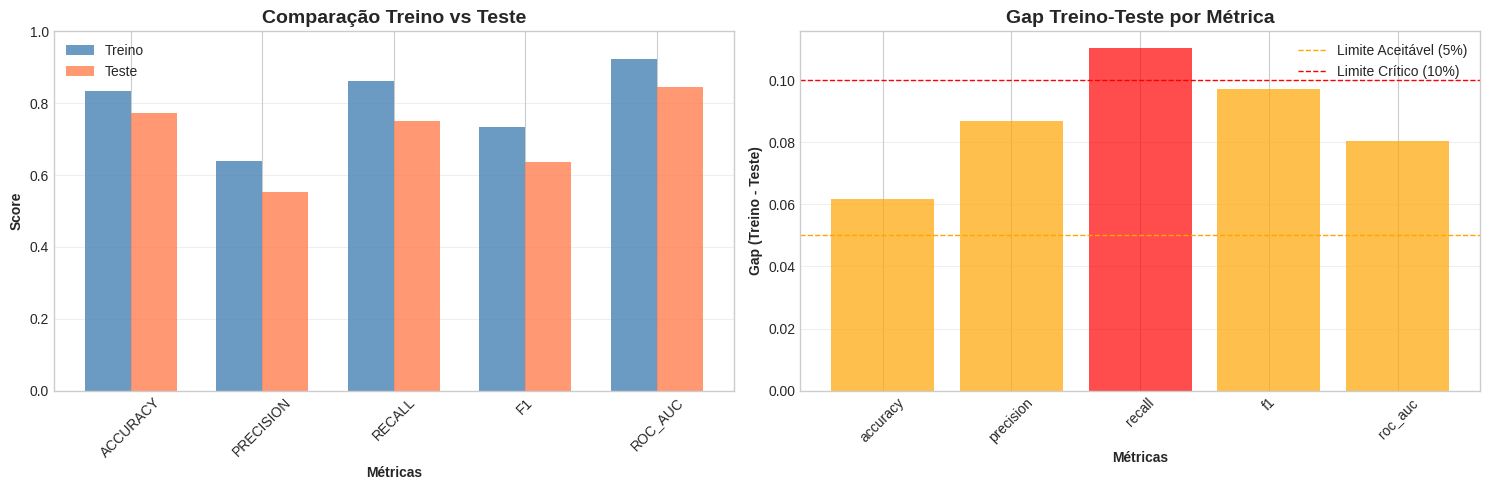

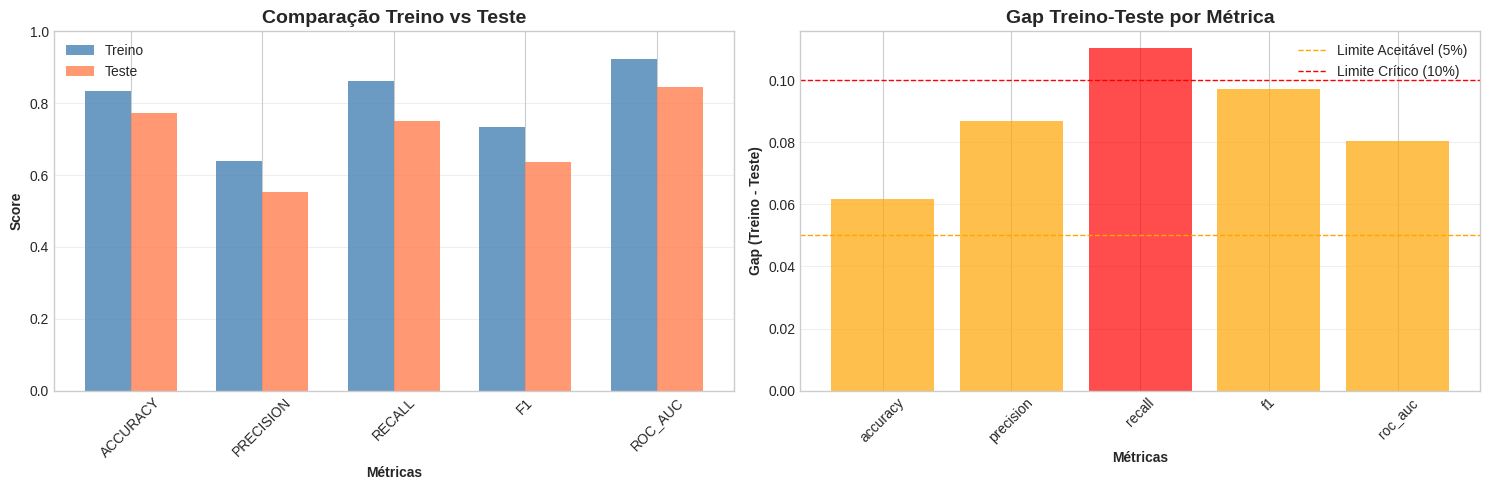

In [29]:
# Visualização
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Comparação Treino vs Teste
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
train_scores = [rf_final_results['train_metrics'][m] for m in metrics]
test_scores = [rf_final_results['test_metrics'][m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, train_scores, width, label='Treino', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, test_scores, width, label='Teste', color='coral', alpha=0.8)
axes[0].set_xlabel('Métricas', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('Comparação Treino vs Teste', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels([m.upper() for m in metrics], rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1)

# Gap por métrica
gaps = [train_scores[i] - test_scores[i] for i in range(len(metrics))]
colors = ['green' if g < 0.05 else 'orange' if g < 0.10 else 'red' for g in gaps]

axes[1].bar(metrics, gaps, color=colors, alpha=0.7)
axes[1].axhline(y=0.05, color='orange', linestyle='--', linewidth=1, label='Limite Aceitável (5%)')
axes[1].axhline(y=0.10, color='red', linestyle='--', linewidth=1, label='Limite Crítico (10%)')
axes[1].set_xlabel('Métricas', fontweight='bold')
axes[1].set_ylabel('Gap (Treino - Teste)', fontweight='bold')
axes[1].set_title('Gap Treino-Teste por Métrica', fontweight='bold', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Feature Importance - Modelo Final

---

**ESTATÍSTICAS DE IMPORTÂNCIA**:

    • Total de features: 64
    • Top 10 acumulam: 51.3% da importância
    • Top 20 acumulam: 76.7% da importância
    • Top 50 acumulam: 96.9% da importância

In [30]:
# Obter importâncias
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_final.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTOP 20 FEATURES MAIS IMPORTANTES:")
display(feature_importance.head(20))

# Estatísticas
print(f"\nESTATÍSTICAS DE IMPORTÂNCIA:")
print(f"   • Total de features: {len(feature_importance)}")
print(f"   • Top 10 acumulam: {feature_importance.head(10)['Importance'].sum()*100:.1f}% da importância")
print(f"   • Top 20 acumulam: {feature_importance.head(20)['Importance'].sum()*100:.1f}% da importância")
print(f"   • Top 50 acumulam: {feature_importance.head(50)['Importance'].sum()*100:.1f}% da importância")



TOP 20 FEATURES MAIS IMPORTANTES:


Feature  Importance
20              IsLongTermContract      0.0698
28              CompositeRiskScore      0.0694
19               IsMonthlyContract      0.0633
6                     ChargesRatio      0.0573
7                     EstimatedCLV      0.0446
2                   MonthlyCharges      0.0439
11                     TenureYears      0.0436
4               AvgChargesPerMonth      0.0434
32               RiskLevel_Encoded      0.0391
1                           tenure      0.0390
29   CompositeRiskScore_Normalized      0.0379
3                     TotalCharges      0.0348
54               Contract_Two year      0.0300
23         HighRiskPaymentContract      0.0280
39     InternetService_Fiber optic      0.0274
5                ChargesDifference      0.0259
30             TenureGroup_Encoded      0.0211
31          TenureQuartile_Encoded      0.0205
57  PaymentMethod_Electronic check      0.0165
40              InternetService_No      0.0112


ESTATÍSTICAS DE IMPORTÂNCIA:
   • Total de features: 64
   • Top 10 acumulam: 51.3% da importância
   • Top 20 acumulam: 76.7% da importância
   • Top 50 acumulam: 96.9% da importância


## 15.1 Visualização de Feature Importance

---

**INSIGHTS:**

    • 50 features explicam 80% da importância do modelo
    • 62 features explicam 90% da importância do modelo

---

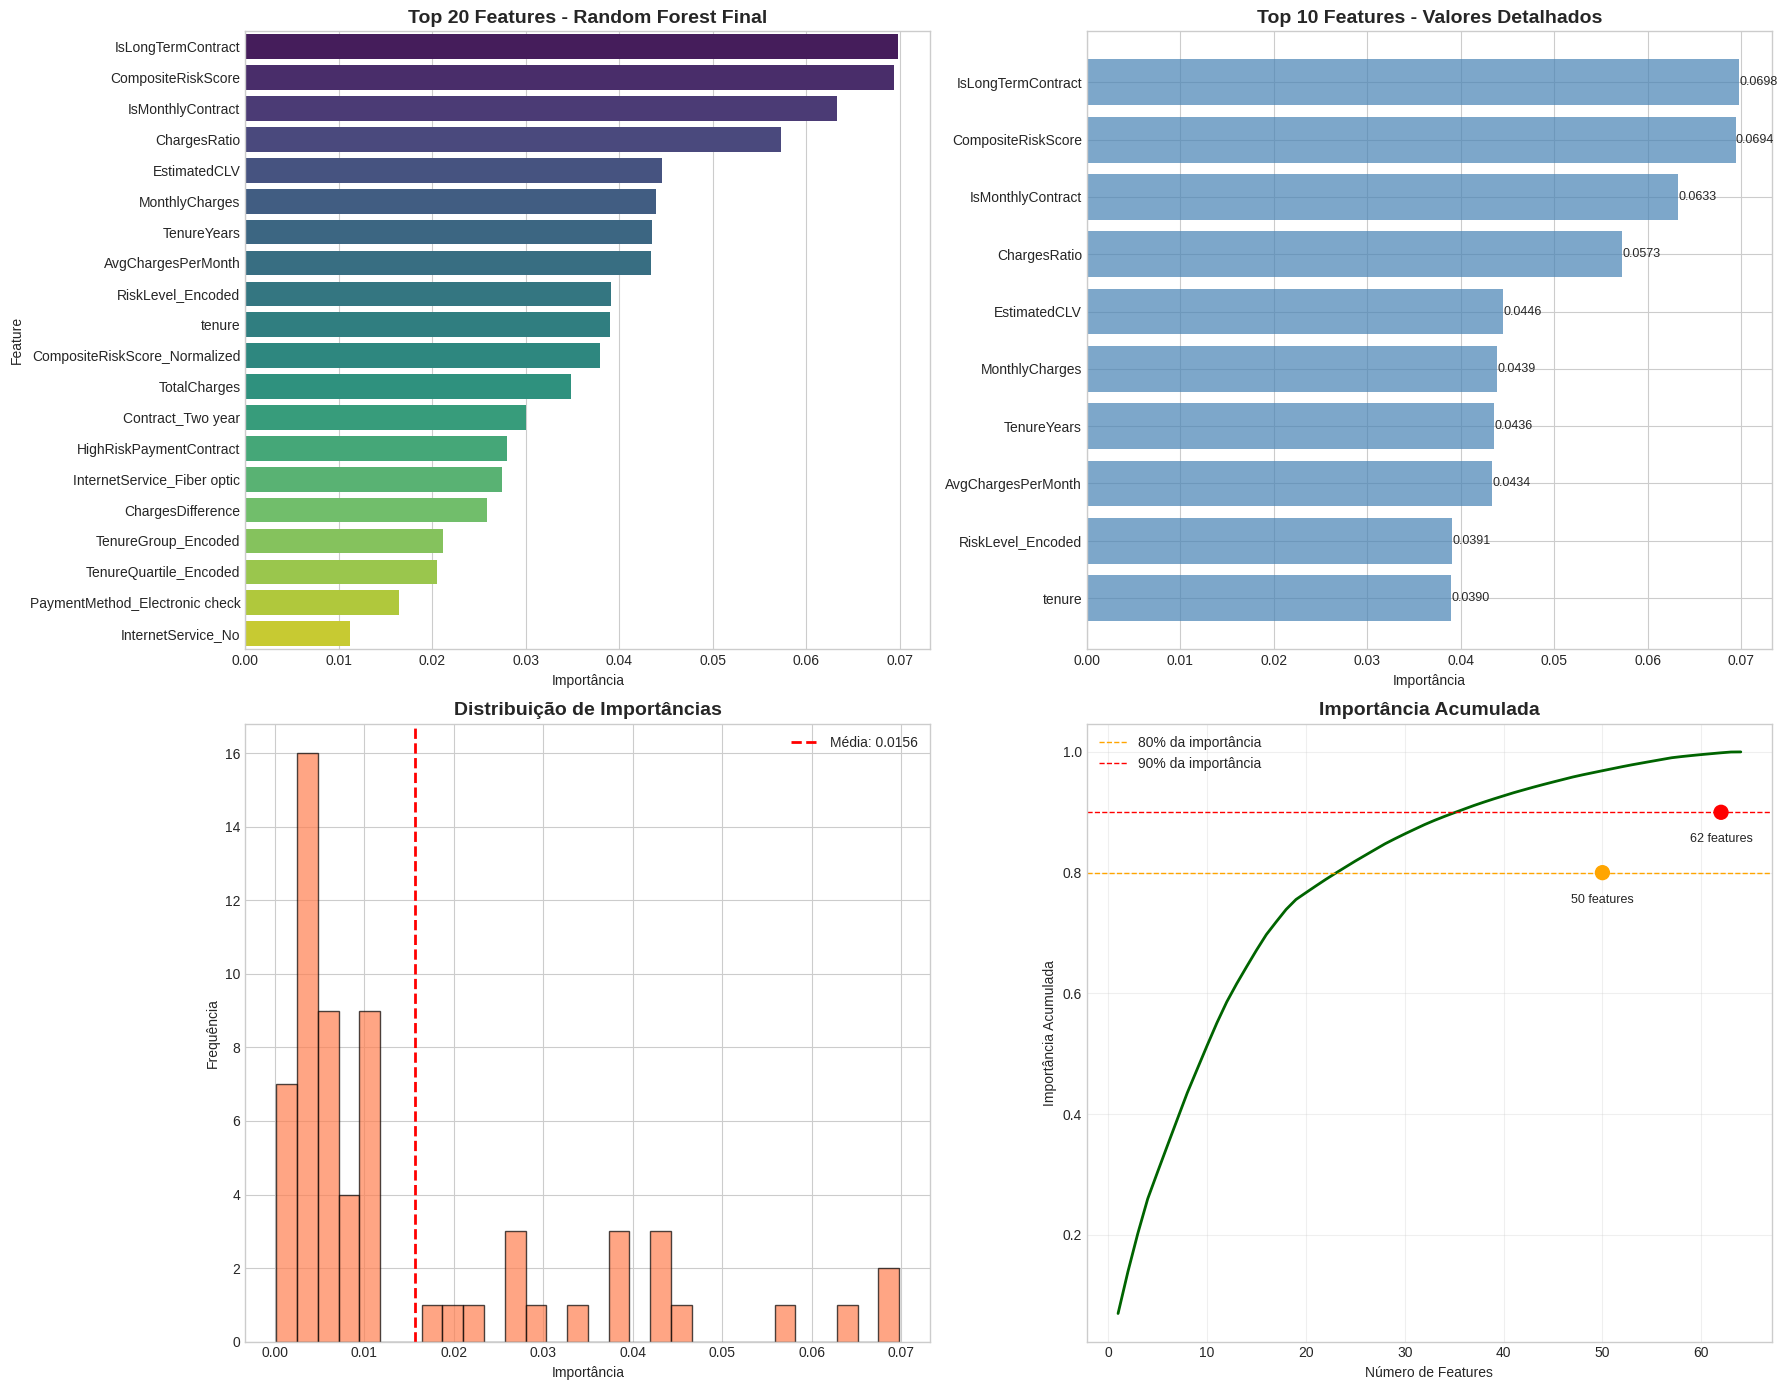

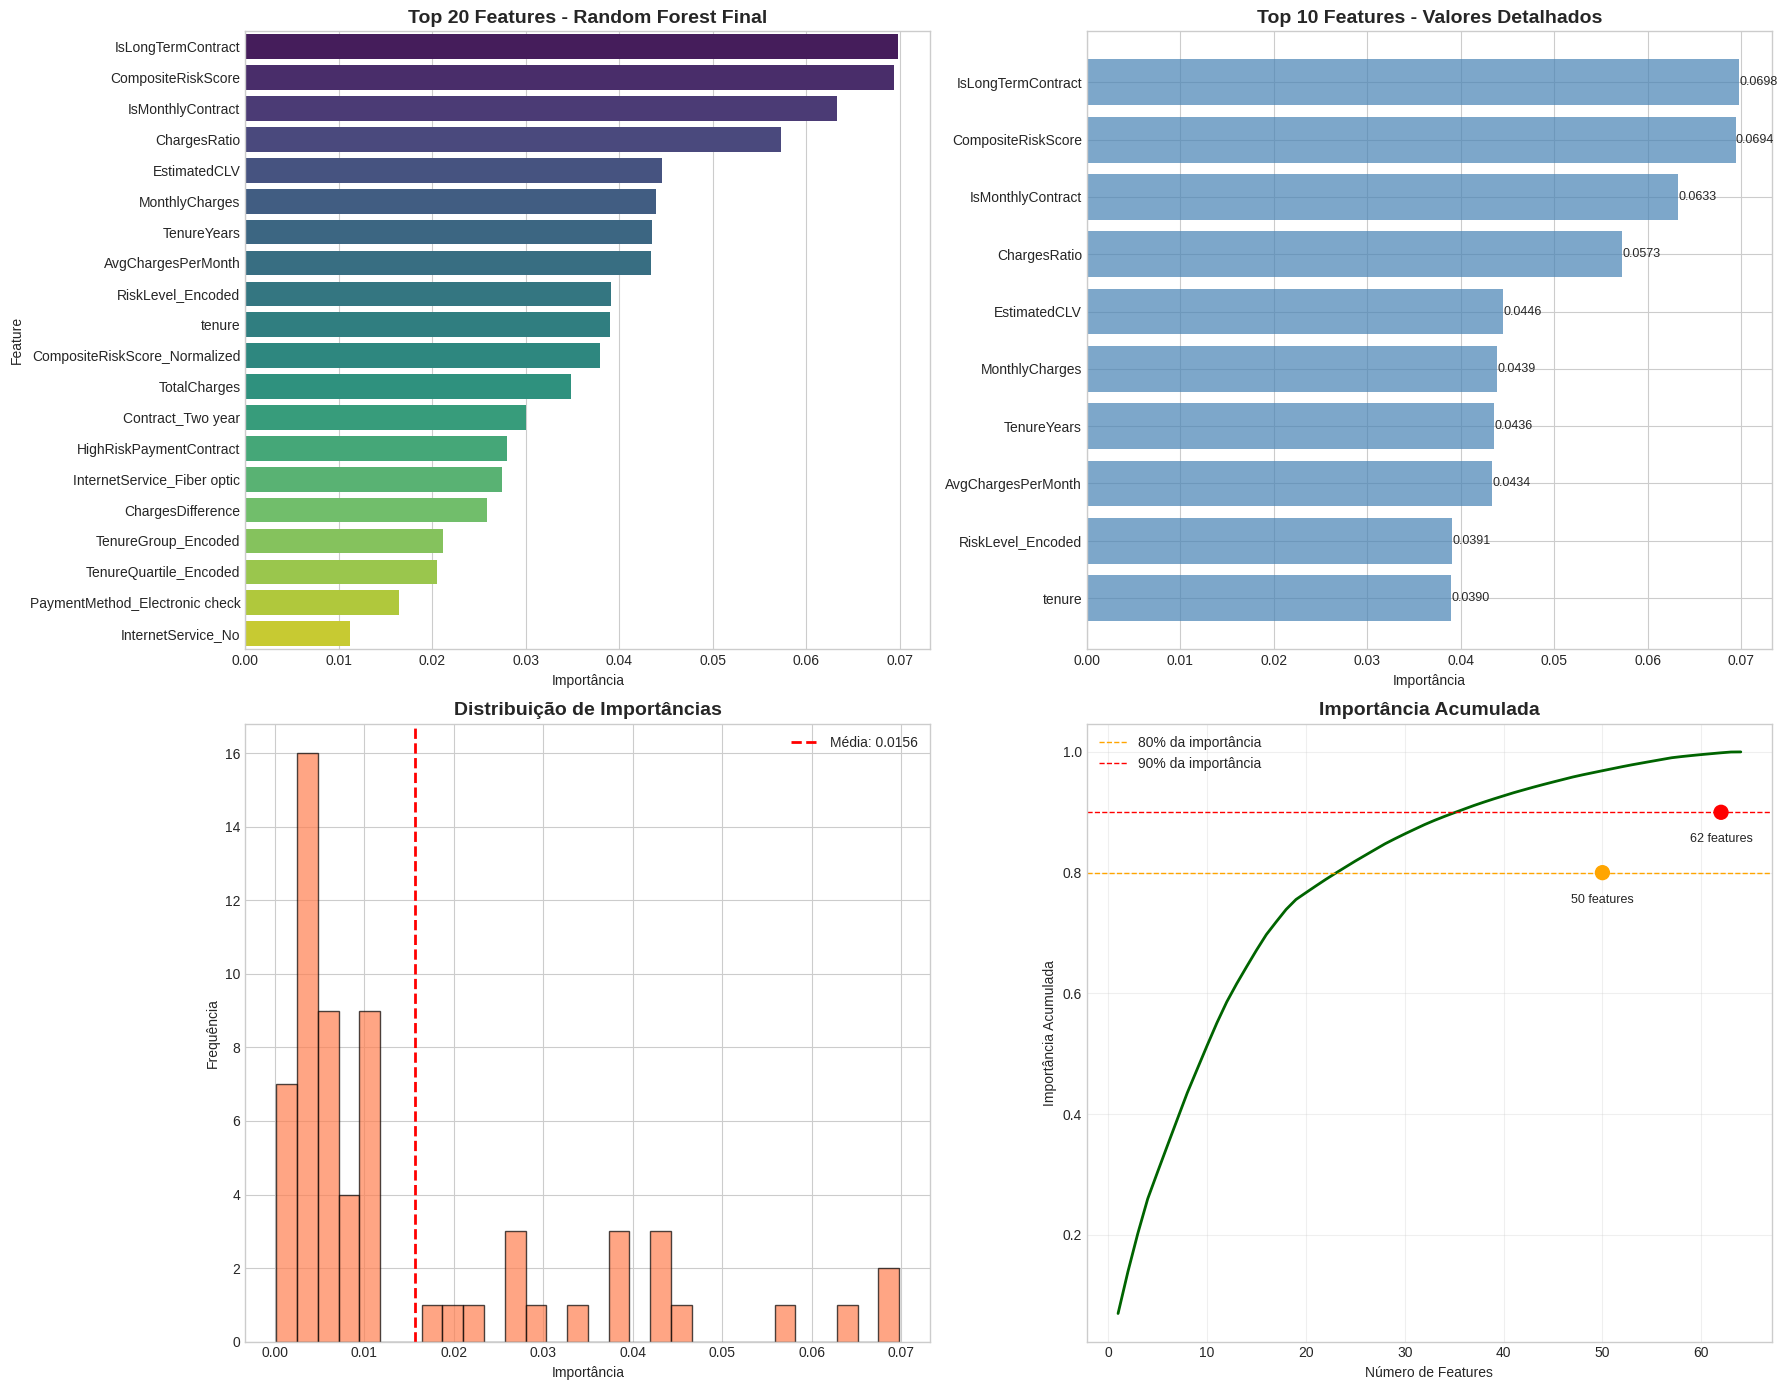

In [31]:
# Visualização detalhada
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Top 20 Features
top_20 = feature_importance.head(20)
sns.barplot(x='Importance', y='Feature', data=top_20, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Top 20 Features - Random Forest Final', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Importância')

# 2. Top 10 com valores
top_10 = feature_importance.head(10)
bars = axes[0, 1].barh(top_10['Feature'], top_10['Importance'], color='steelblue', alpha=0.7)
axes[0, 1].set_title('Top 10 Features - Valores Detalhados', fontweight='bold', fontsize=14)
axes[0, 1].set_xlabel('Importância')
axes[0, 1].invert_yaxis()

# Adicionar valores nas barras
for bar in bars:
    width = bar.get_width()
    axes[0, 1].text(width, bar.get_y() + bar.get_height()/2,
                    f'{width:.4f}', ha='left', va='center', fontsize=9)

# 3. Distribuição de importâncias
axes[1, 0].hist(feature_importance['Importance'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribuição de Importâncias', fontweight='bold', fontsize=14)
axes[1, 0].set_xlabel('Importância')
axes[1, 0].set_ylabel('Frequência')
axes[1, 0].axvline(feature_importance['Importance'].mean(), color='red',
                   linestyle='--', linewidth=2, label=f'Média: {feature_importance["Importance"].mean():.4f}')
axes[1, 0].legend()

# 4. Importância acumulada
cumsum_importance = feature_importance['Importance'].cumsum()
axes[1, 1].plot(range(1, len(cumsum_importance)+1), cumsum_importance, linewidth=2, color='darkgreen')
axes[1, 1].axhline(y=0.8, color='orange', linestyle='--', linewidth=1, label='80% da importância')
axes[1, 1].axhline(y=0.9, color='red', linestyle='--', linewidth=1, label='90% da importância')
axes[1, 1].set_title('Importância Acumulada', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('Número de Features')
axes[1, 1].set_ylabel('Importância Acumulada')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Marcar quantas features para 80% e 90%
features_80 = (cumsum_importance >= 0.8).idxmax() + 1
features_90 = (cumsum_importance >= 0.9).idxmax() + 1
axes[1, 1].scatter([features_80, features_90], [0.8, 0.9],
                   s=100, c=['orange', 'red'], zorder=5)
axes[1, 1].text(features_80, 0.75, f'{features_80} features', ha='center', fontsize=9)
axes[1, 1].text(features_90, 0.85, f'{features_90} features', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [32]:
print(f"\nINSIGHTS:")
print(f"   • {features_80} features explicam 80% da importância do modelo")
print(f"   • {features_90} features explicam 90% da importância do modelo")


INSIGHTS:
   • 50 features explicam 80% da importância do modelo
   • 62 features explicam 90% da importância do modelo


## 15.2 Análise das Features Mais Importantes

----

**COMPOSIÇÃO DO TOP 10:**

     • Features Criadas: 8 (80%)
     • Features Originais: 2 (20%)

---

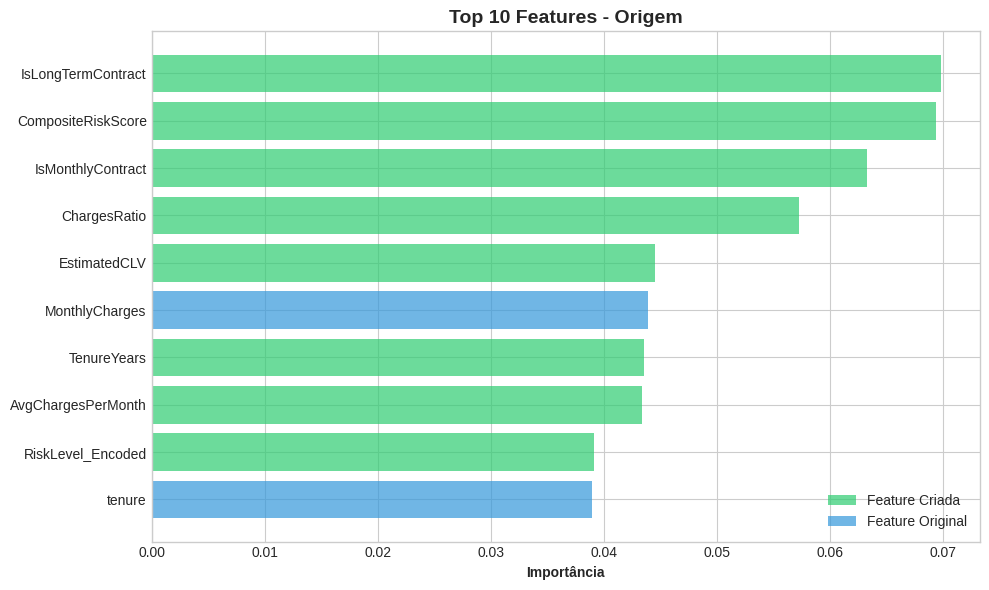

In [33]:
# Analisar top 10 features
top_10_features = feature_importance.head(10)['Feature'].tolist()

# Verificar se são features criadas ou originais
# (assumindo que features criadas têm nomes específicos)
created_features_keywords = [
    'Avg', 'Difference', 'Ratio', 'CLV', 'HighValue', 'Group', 'IsNew',
    'IsVeteran', 'Years', 'Quartile', 'Total', 'HasMany', 'NoAdditional',
    'Security', 'Streaming', 'InternetWithout', 'IsMonthly', 'IsLongTerm',
    'IsElectronic', 'IsAutomatic', 'HighRisk', 'IsAlone', 'HasFamily',
    'SeniorAlone', 'Demographic', 'Composite', 'Risk'
]

for idx, feat in enumerate(top_10_features, 1):
    importance = feature_importance[feature_importance['Feature'] == feat]['Importance'].values[0]

    # Verificar se é feature criada
    is_created = any(keyword in feat for keyword in created_features_keywords)
    origin = "Criada" if is_created else "Original"

    print(f"\n{idx}. {feat}")
    print(f"   {origin}")
    print(f"   Importância: {importance:.4f} ({importance*100:.2f}%)")



1. IsLongTermContract
   Criada
   Importância: 0.0698 (6.98%)

2. CompositeRiskScore
   Criada
   Importância: 0.0694 (6.94%)

3. IsMonthlyContract
   Criada
   Importância: 0.0633 (6.33%)

4. ChargesRatio
   Criada
   Importância: 0.0573 (5.73%)

5. EstimatedCLV
   Criada
   Importância: 0.0446 (4.46%)

6. MonthlyCharges
   Original
   Importância: 0.0439 (4.39%)

7. TenureYears
   Criada
   Importância: 0.0436 (4.36%)

8. AvgChargesPerMonth
   Criada
   Importância: 0.0434 (4.34%)

9. RiskLevel_Encoded
   Criada
   Importância: 0.0391 (3.91%)

10. tenure
   Original
   Importância: 0.0390 (3.90%)


In [34]:
# Contar features criadas vs originais no top 10
created_count = sum(1 for feat in top_10_features
                   if any(keyword in feat for keyword in created_features_keywords))
original_count = 10 - created_count

print(f"\nCOMPOSIÇÃO DO TOP 10:")
print(f"   • Features Criadas: {created_count} ({created_count/10*100:.0f}%)")
print(f"   • Features Originais: {original_count} ({original_count/10*100:.0f}%)")



COMPOSIÇÃO DO TOP 10:
   • Features Criadas: 8 (80%)
   • Features Originais: 2 (20%)


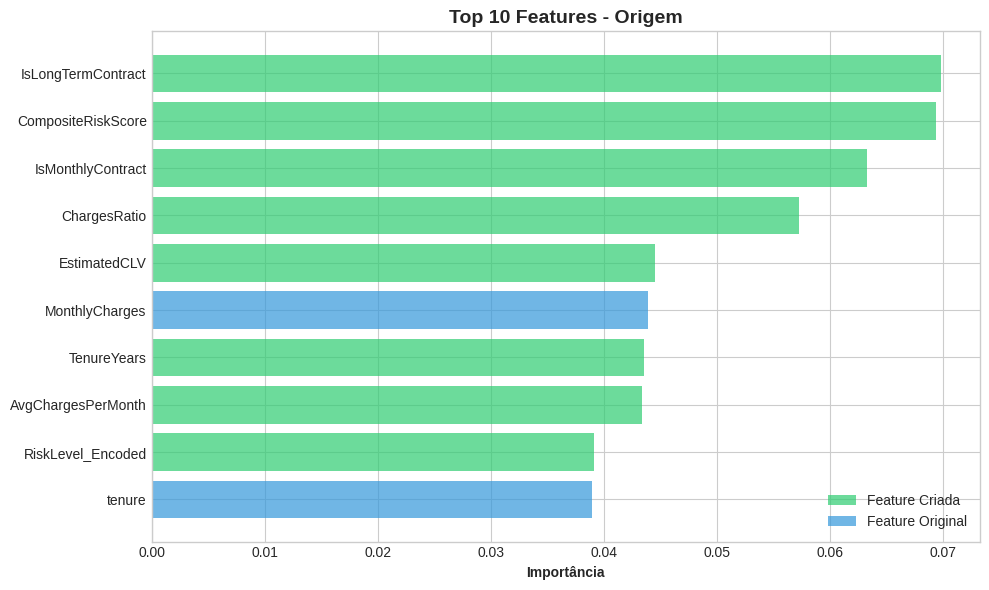

In [35]:
# Visualização
fig, ax = plt.subplots(figsize=(10, 6))

origins = ['Criada' if any(kw in feat for kw in created_features_keywords) else 'Original'
           for feat in top_10_features]
colors_map = {'Criada': '#2ecc71', 'Original': '#3498db'}
colors = [colors_map[o] for o in origins]

bars = ax.barh(top_10_features, top_10['Importance'], color=colors, alpha=0.7)
ax.set_xlabel('Importância', fontweight='bold')
ax.set_title('Top 10 Features - Origem', fontweight='bold', fontsize=14)
ax.invert_yaxis()

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', alpha=0.7, label='Feature Criada'),
    Patch(facecolor='#3498db', alpha=0.7, label='Feature Original')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 16. SHAP Values - Interpretabilidade do Modelo

---

In [36]:
# Criar explainer SHAP para Random Forest
print("\nCalculando SHAP values (pode demorar alguns minutos)...")
print("   Usando amostra de 1000 observações para acelerar o cálculo...")

# Usar amostra para acelerar
sample_size = min(1000, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)

explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_test_sample)

# Para classificação binária, pegar valores da classe positiva (churn=1)
if isinstance(shap_values, list):
    shap_values_positive = shap_values[1]
else:
    shap_values_positive = shap_values

print("SHAP values calculados!")


Calculando SHAP values (pode demorar alguns minutos)...
   Usando amostra de 1000 observações para acelerar o cálculo...
SHAP values calculados!


## 16.1 SHAP Summary Plot

---



<Figure size 1200x800 with 0 Axes>

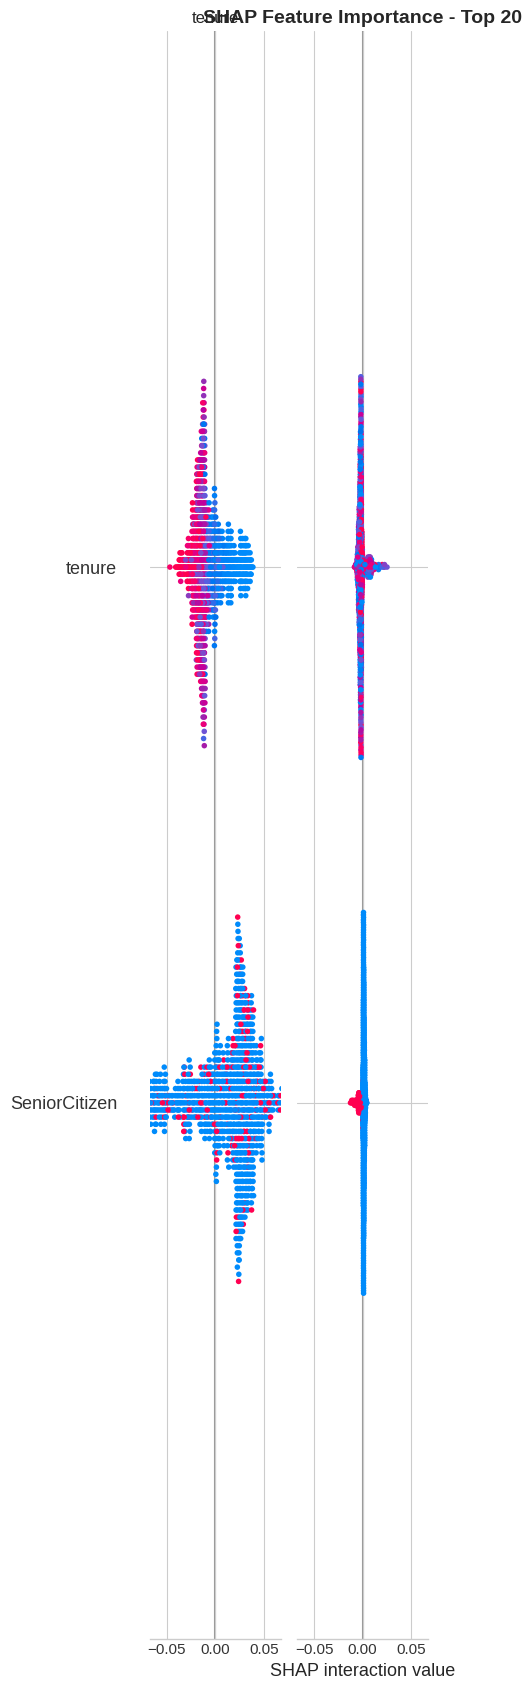

In [37]:
# Summary plot (importância)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_positive, X_test_sample, plot_type="bar", show=False, max_display=20)
plt.title('SHAP Feature Importance - Top 20', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

## 16.2 SHAP Detailed Summary (Impacto Direcional)

---

INTERPRETAÇÃO DO GRÁFICO:

    • Eixo X: Impacto no SHAP value (positivo = aumenta probabilidade de churn)

    • Cor: Valor da feature (vermelho = alto, azul = baixo)
    
    • Cada ponto: Uma observação

<Figure size 1200x1000 with 0 Axes>

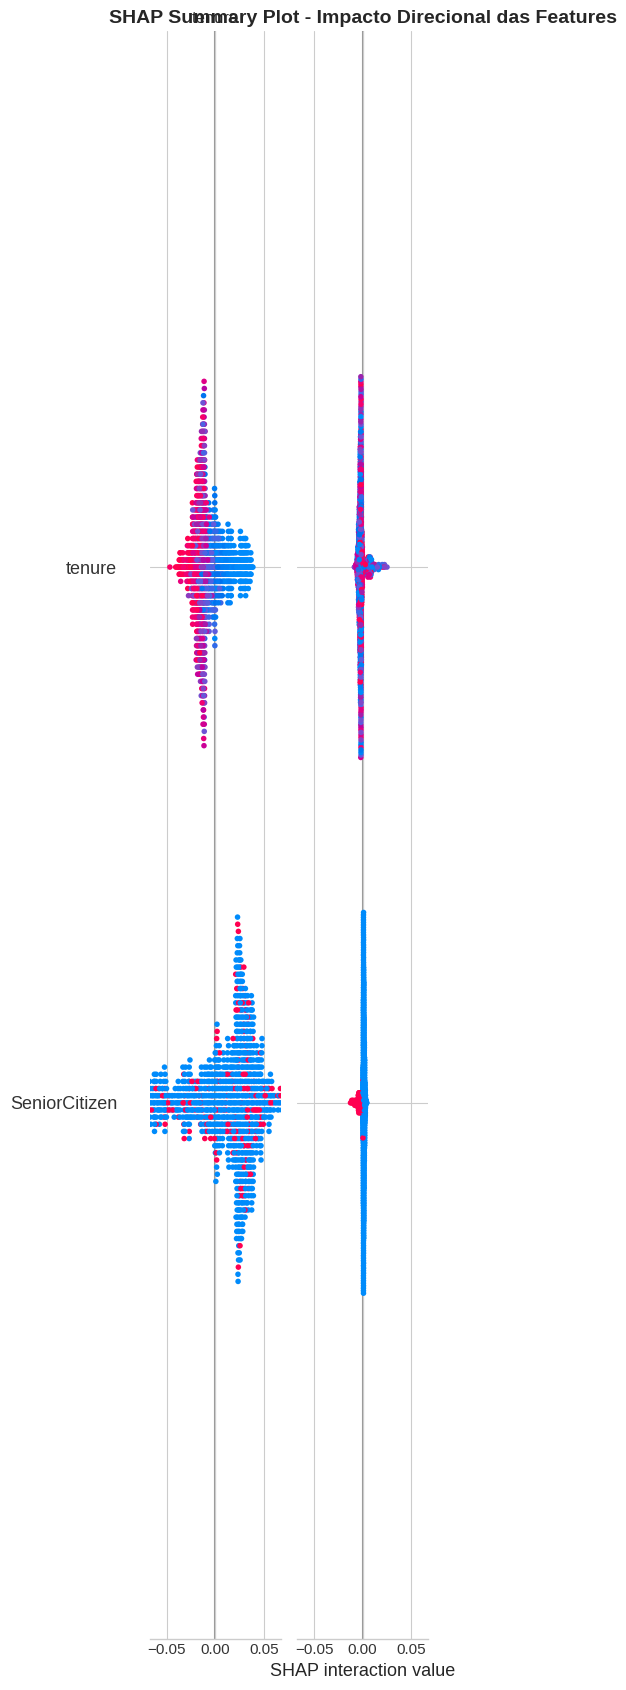


INTERPRETAÇÃO DO GRÁFICO:
   • Eixo X: Impacto no SHAP value (positivo = aumenta probabilidade de churn)
   • Cor: Valor da feature (vermelho = alto, azul = baixo)
   • Cada ponto: Uma observação


In [38]:
# Detailed summary plot (impacto direcional)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_positive, X_test_sample, show=False, max_display=20)
plt.title('SHAP Summary Plot - Impacto Direcional das Features', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("\nINTERPRETAÇÃO DO GRÁFICO:")
print("   • Eixo X: Impacto no SHAP value (positivo = aumenta probabilidade de churn)")
print("   • Cor: Valor da feature (vermelho = alto, azul = baixo)")
print("   • Cada ponto: Uma observação")

## 16.3 SHAP Dependence Plots - Top Features

---

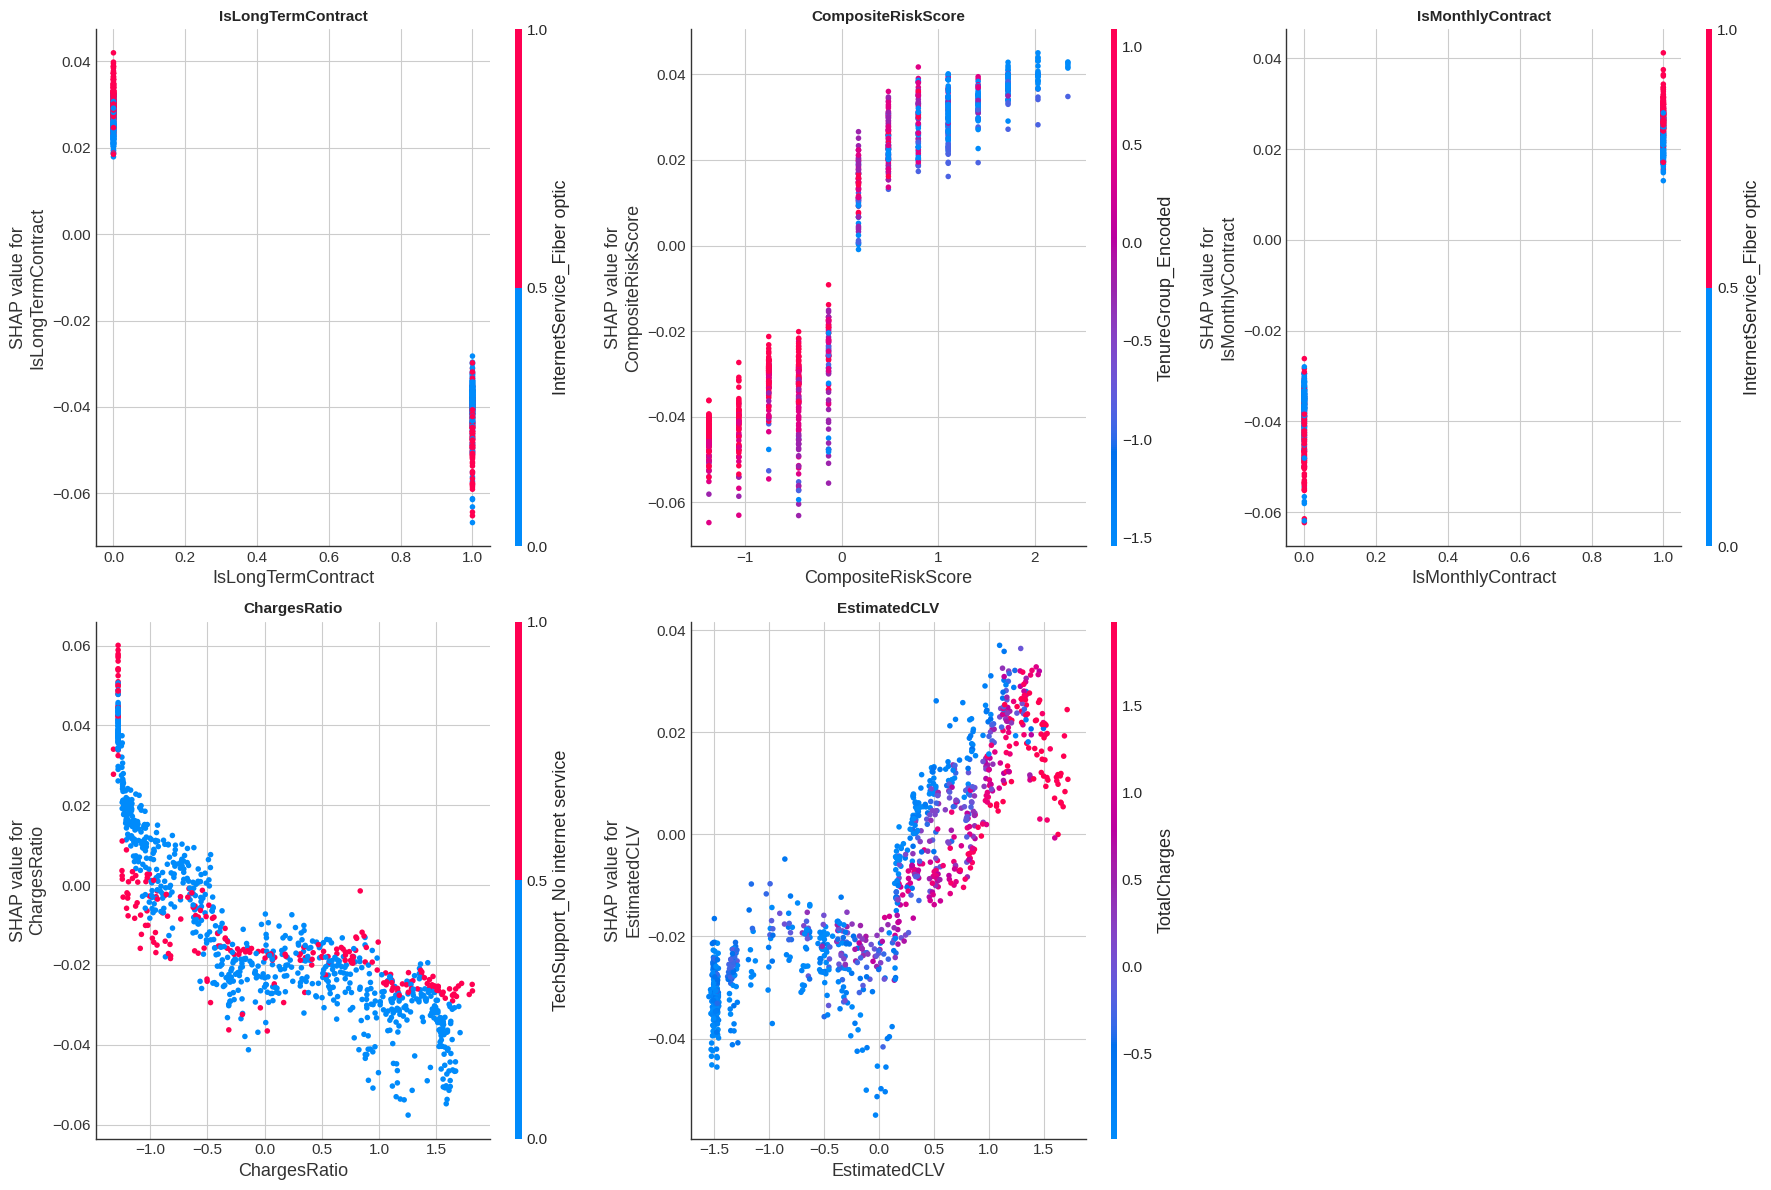

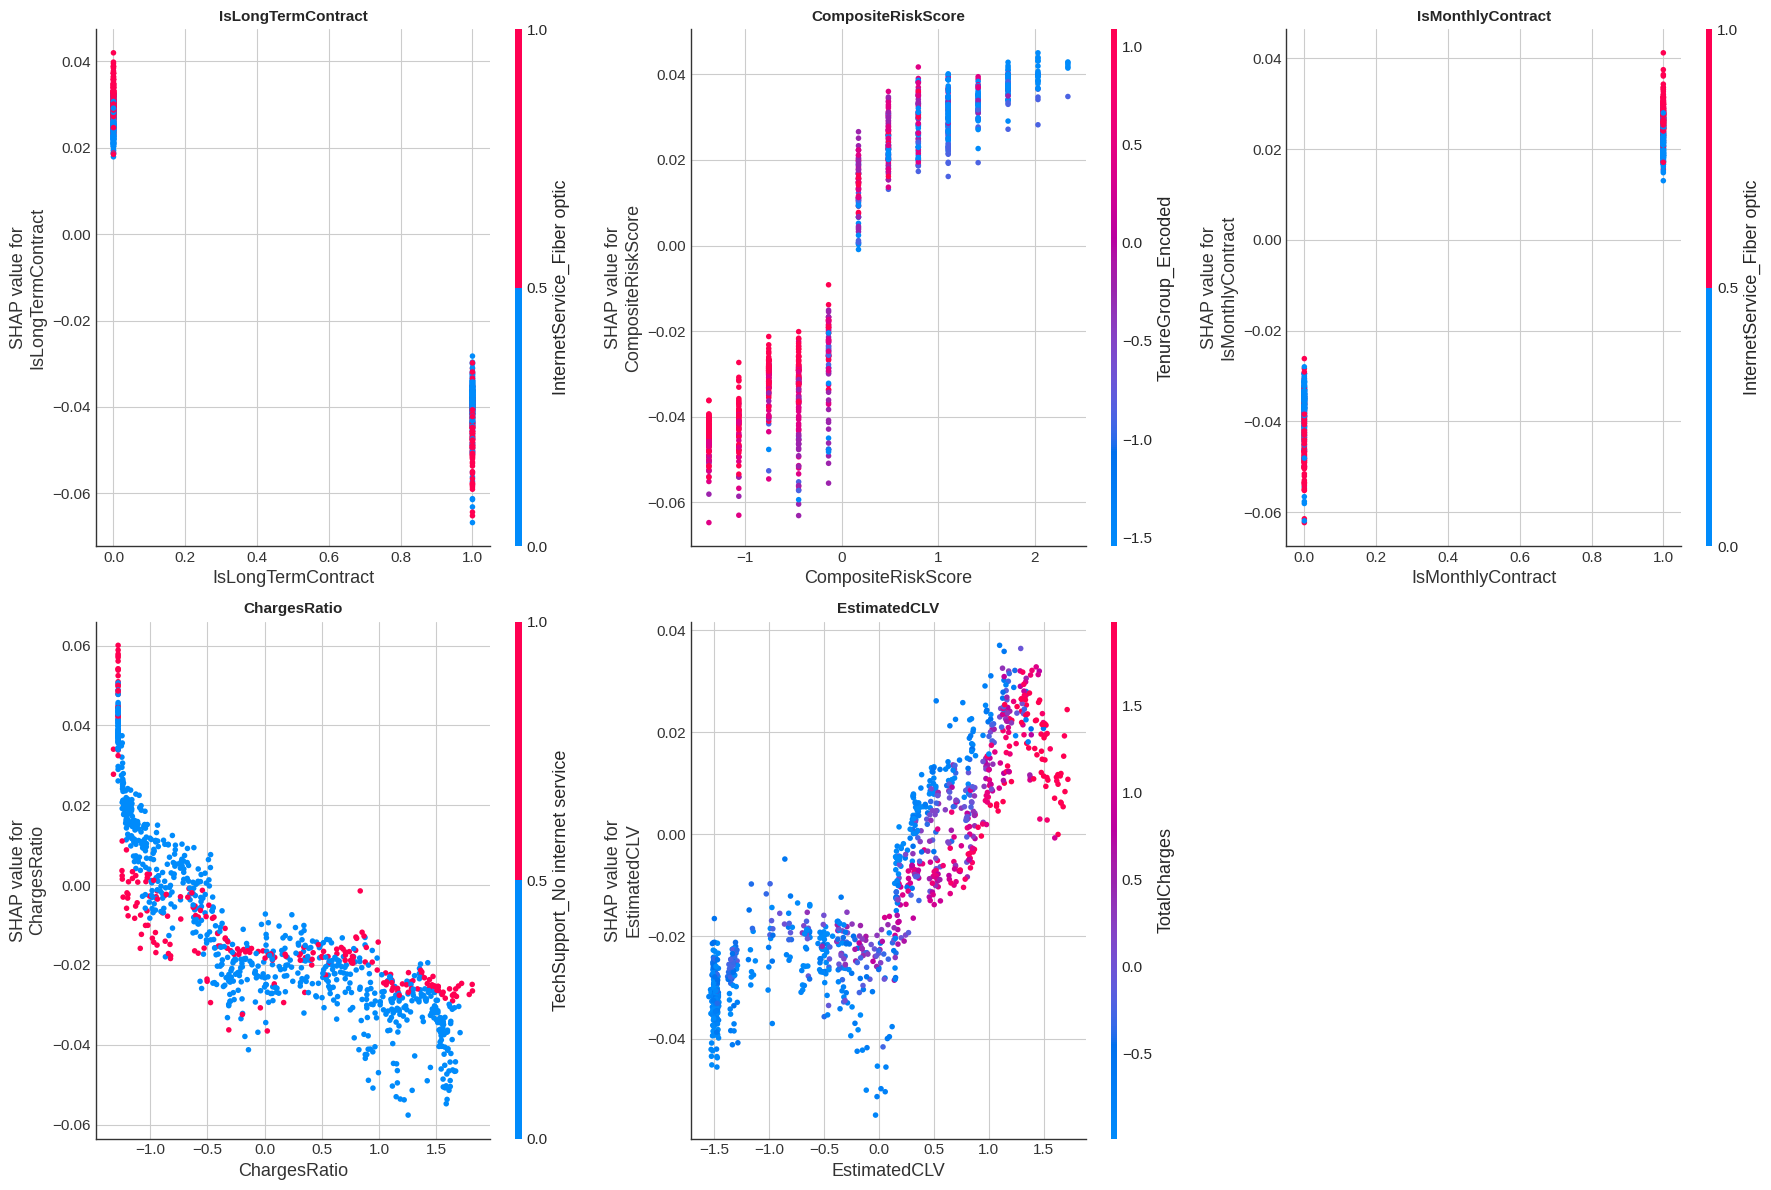

In [40]:
# Plotar dependence plots para top 5 features
top_5_features = feature_importance.head(5)['Feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Garantir que shap_values_for_plot seja 2D (n_samples, n_features)
# Com base no estado do kernel, shap_values_positive (Variável nº 15) é uma matriz 3D.
# Precisamos extrair os valores SHAP para a classe positiva (índice 1) como uma matriz 2D.
if shap_values_positive.ndim == 3 and shap_values_positive.shape[2] > 1:
    shap_values_for_plot = shap_values_positive[:, :, 1]
elif shap_values_positive.ndim == 2:
    shap_values_for_plot = shap_values_positive
else:
    print("Aviso: shap_values_positive possui um número inesperado de dimensões. Tentando prosseguir assumindo que seja 2D para fins de plotagem.")
    shap_values_for_plot = shap_values_positive


for idx, feature in enumerate(top_5_features):
    if feature in X_test_sample.columns:
        shap.dependence_plot(
            feature,
            shap_values_for_plot,  # Use os valores de forma 2D formatados corretamente
            X_test_sample,
            ax=axes[idx],
            show=False
        )
        axes[idx].set_title(f'{feature}', fontweight='bold', fontsize=11)

# Remover subplot extra
axes[-1].remove()

plt.tight_layout()
plt.show()

## 16.4 SHAP Force Plot - Exemplos de Clientes

----

CLIENTE DE ALTO RISCO (Predição Correta):

    • Índice: 9
    • Probabilidade de churn: 83.08%
    • Churn real: Sim

---

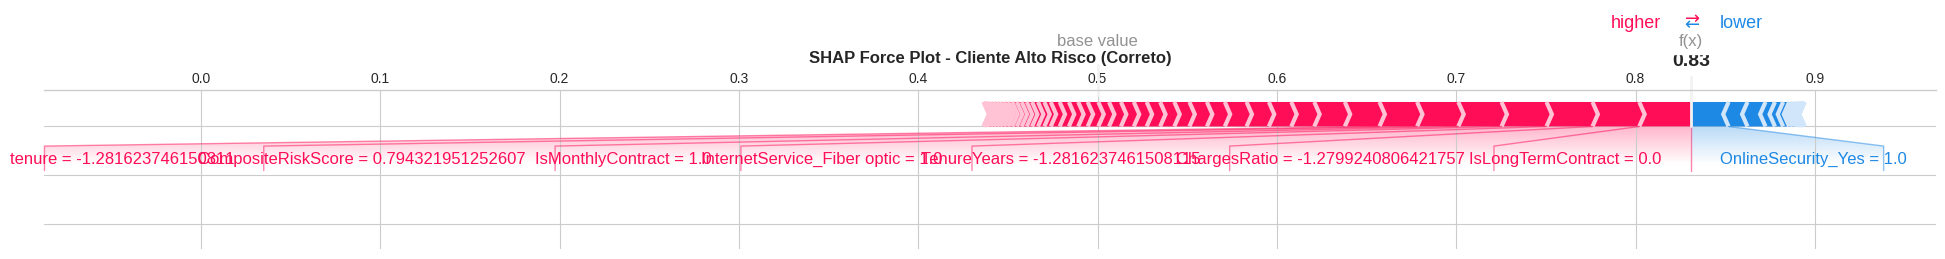

---

 CLIENTE DE BAIXO RISCO (Predição Correta):

    • Índice: 2
    • Probabilidade de churn: 1.18%
    • Churn real: Não

  ----
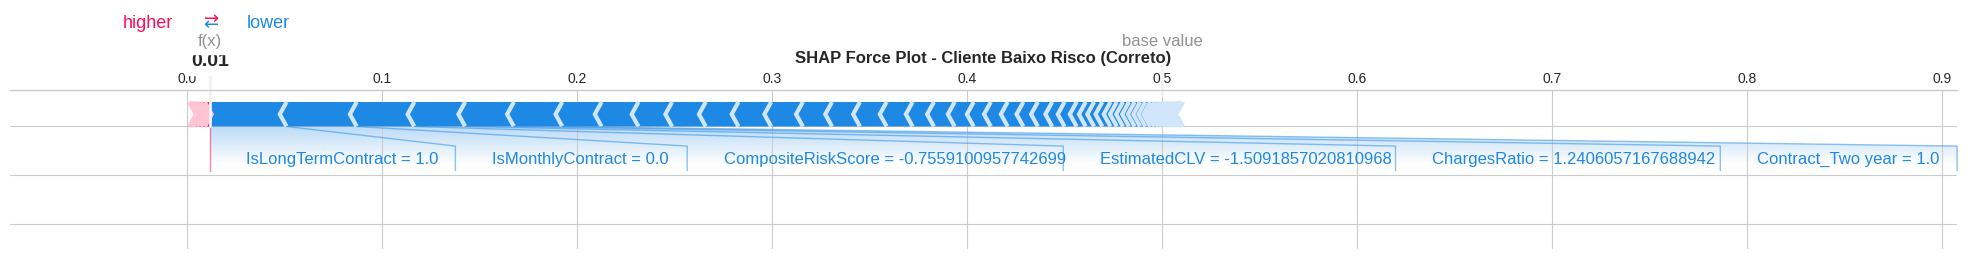


  ----


  FALSO NEGATIVO (Churn não identificado):

    • Índice: 7
    • Probabilidade de churn: 19.24%
    • Churn real: Sim (mas predito como Não)
------

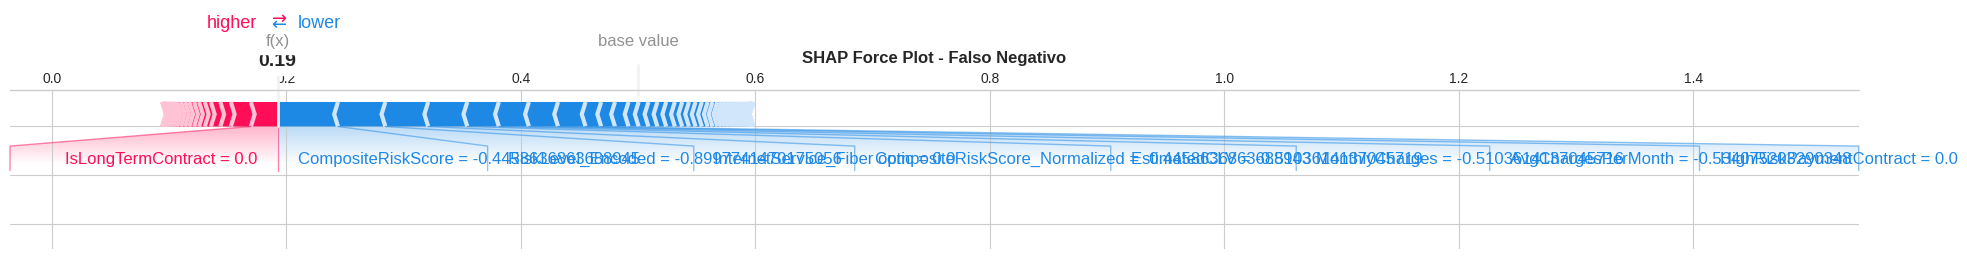


CLIENTE DE ALTO RISCO (Predição Correta):
   • Índice: 9
   • Probabilidade de churn: 83.08%
   • Churn real: Sim


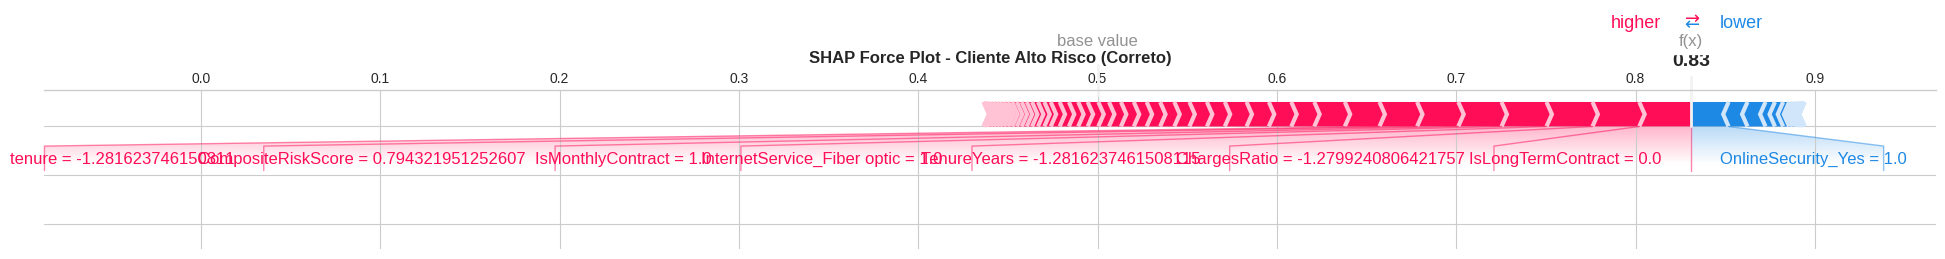

In [43]:
# Selecionar exemplos interessantes
y_test_sample = y_test.loc[X_test_sample.index]
y_proba_sample = rf_final.predict_proba(X_test_sample)[:, 1]

# Converter shap_values ​​(lista de arrays 2D) em um array 3D, se necessário
# Isso garante o formato correto para force_plot com modelos de múltiplas saídas, conforme indicado pelo erro
if isinstance(shap_values, list):
    shap_values_3d = np.stack(shap_values, axis=-1) # (n_samples, n_features, n_classes)
else:
    shap_values_3d = shap_values # Suponha que já seja uma matriz 3D ou uma única matriz 2D, caso contrário, será uma lista.

# 1. Cliente com ALTA probabilidade de churn (correto)
high_risk_correct = np.where((y_proba_sample > 0.8) & (y_test_sample == 1))[0]
if len(high_risk_correct) > 0:
    idx_high = high_risk_correct[0]
    print(f"\nCLIENTE DE ALTO RISCO (Predição Correta):")
    print(f"   • Índice: {idx_high}")
    print(f"   • Probabilidade de churn: {y_proba_sample[idx_high]:.2%}")
    print(f"   • Churn real: Sim")

    shap.force_plot(
        explainer.expected_value[1],         # Valor base para a classe positiva (churn=1)
        shap_values_3d[idx_high, :, 1],      # Valores SHAP para a instância idx_high, todas as características, classe 1 (matriz 1D)
        X_test_sample.iloc[idx_high],        # Valores de recursos para a instância idx_high (Série pandas)
        matplotlib=True,
        show=False
    )
    plt.title(f'SHAP Force Plot - Cliente Alto Risco (Correto)', fontweight='bold')
    plt.tight_layout()
    plt.show()


 CLIENTE DE BAIXO RISCO (Predição Correta):
   • Índice: 2
   • Probabilidade de churn: 1.18%
   • Churn real: Não


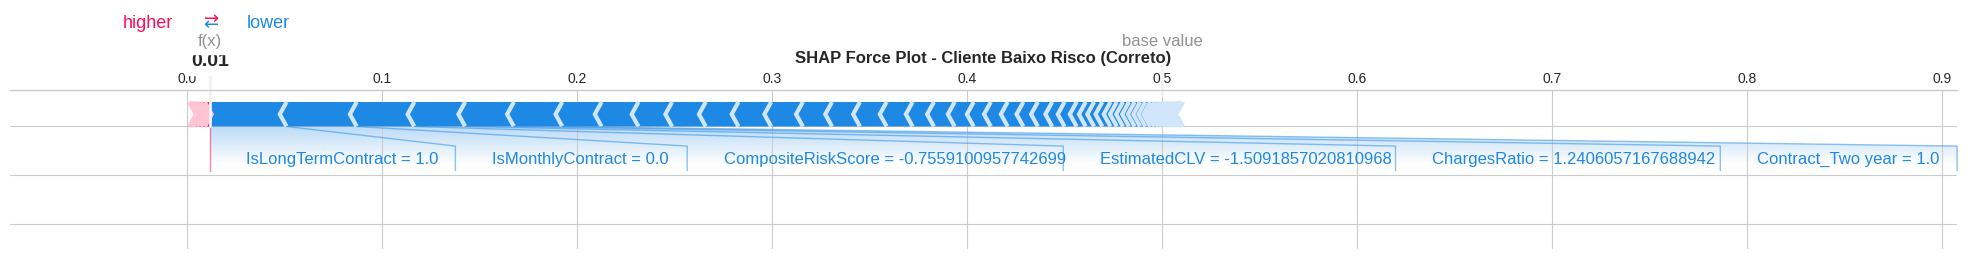

In [45]:
# 2. Cliente com BAIXA probabilidade de churn (correto)
low_risk_correct = np.where((y_proba_sample < 0.2) & (y_test_sample == 0))[0]
if len(low_risk_correct) > 0:
    idx_low = low_risk_correct[0]
    print(f"\n CLIENTE DE BAIXO RISCO (Predição Correta):")
    print(f"   • Índice: {idx_low}")
    print(f"   • Probabilidade de churn: {y_proba_sample[idx_low]:.2%}")
    print(f"   • Churn real: Não")

    shap.force_plot(
        explainer.expected_value[1],
        shap_values_3d[idx_low, :, 1],
        X_test_sample.iloc[idx_low],
        matplotlib=True,
        show=False
    )
    plt.title(f'SHAP Force Plot - Cliente Baixo Risco (Correto)', fontweight='bold')
    plt.tight_layout()
    plt.show()


FALSO NEGATIVO (Churn não identificado):
   • Índice: 7
   • Probabilidade de churn: 19.24%
   • Churn real: Sim (mas predito como Não)


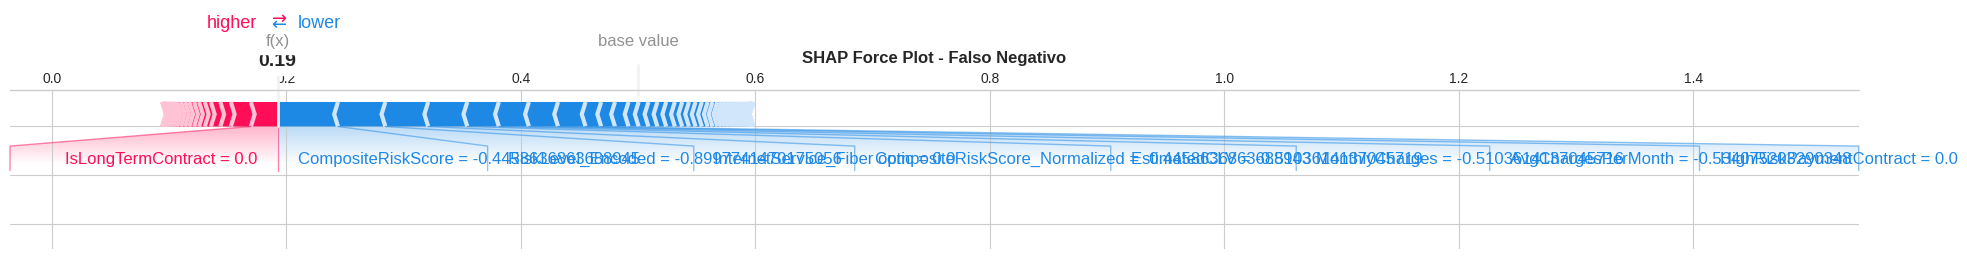

In [47]:
# 3. Falso Negativo (alto risco mas não identificado)
false_negatives = np.where((y_proba_sample < 0.5) & (y_test_sample == 1))[0]
if len(false_negatives) > 0:
    idx_fn = false_negatives[0]
    print(f"\nFALSO NEGATIVO (Churn não identificado):")
    print(f"   • Índice: {idx_fn}")
    print(f"   • Probabilidade de churn: {y_proba_sample[idx_fn]:.2%}")
    print(f"   • Churn real: Sim (mas predito como Não)")

    shap.force_plot(
        explainer.expected_value[1],
        shap_values_3d[idx_fn, :, 1],
        X_test_sample.iloc[idx_fn],
        matplotlib=True,
        show=False
    )
    plt.title(f'SHAP Force Plot - Falso Negativo', fontweight='bold')
    plt.tight_layout()
    plt.show()

## 17. Análise de Erros Detalhada

----

DISTRIBUIÇÃO DE PREDIÇÕES:

    • Correto: 1088 (77.2%)
    • Falso Positivo: 228 (16.2%)
    • Falso Negativo: 93 (6.6%)

In [48]:
# Criar DataFrame com predições
error_analysis = pd.DataFrame({
    'Real': y_test.values,
    'Predito': rf_final_results['y_pred_test'],
    'Probabilidade': rf_final_results['y_proba_test']
})

# Adicionar features importantes para análise
important_features = feature_importance.head(15)['Feature'].tolist()
for feat in important_features:
    if feat in X_test.columns:
        error_analysis[feat] = X_test[feat].values

# Classificar erros
error_analysis['Tipo'] = 'Correto'
error_analysis.loc[(error_analysis['Real'] == 1) & (error_analysis['Predito'] == 0), 'Tipo'] = 'Falso Negativo'
error_analysis.loc[(error_analysis['Real'] == 0) & (error_analysis['Predito'] == 1), 'Tipo'] = 'Falso Positivo'

# Estatísticas gerais
print(f"\nDISTRIBUIÇÃO DE PREDIÇÕES:")
tipo_counts = error_analysis['Tipo'].value_counts()
for tipo, count in tipo_counts.items():
    pct = count / len(error_analysis) * 100
    print(f"   • {tipo}: {count} ({pct:.1f}%)")


DISTRIBUIÇÃO DE PREDIÇÕES:
   • Correto: 1088 (77.2%)
   • Falso Positivo: 228 (16.2%)
   • Falso Negativo: 93 (6.6%)


## 17.1 Análise de Falsos Negativos (Crítico)


---

    Total de Falsos Negativos: 93 (6.6%)
    Probabilidade média: 30.46%
    Probabilidade mediana: 31.88%
    Range de probabilidades: [2.97%, 49.93%]

CARACTERÍSTICAS DOS FALSOS NEGATIVOS:

(Clientes que fizeram churn mas o modelo não identificou)

In [49]:
fn_cases = error_analysis[error_analysis['Tipo'] == 'Falso Negativo']

print(f"\nTotal de Falsos Negativos: {len(fn_cases)} ({len(fn_cases)/len(y_test)*100:.1f}%)")
print(f"Probabilidade média: {fn_cases['Probabilidade'].mean():.2%}")
print(f"Probabilidade mediana: {fn_cases['Probabilidade'].median():.2%}")
print(f"Range de probabilidades: [{fn_cases['Probabilidade'].min():.2%}, {fn_cases['Probabilidade'].max():.2%}]")

print(f"\nCARACTERÍSTICAS DOS FALSOS NEGATIVOS:")
print(f"(Clientes que fizeram churn mas o modelo não identificou)")


Total de Falsos Negativos: 93 (6.6%)
Probabilidade média: 30.46%
Probabilidade mediana: 31.88%
Range de probabilidades: [2.97%, 49.93%]

CARACTERÍSTICAS DOS FALSOS NEGATIVOS:
(Clientes que fizeram churn mas o modelo não identificou)


In [50]:
# Estatísticas das features importantes
available_features = [f for f in important_features if f in fn_cases.columns]
if len(available_features) > 0:
    print(f"\nMédia das features principais:")
    display(fn_cases[available_features].describe().T[['mean', '50%', 'min', 'max']])


Média das features principais:


mean     50%     min     max
IsLongTermContract             0.4624  0.0000  0.0000  1.0000
CompositeRiskScore            -0.1525 -0.1358 -1.3760  2.0345
IsMonthlyContract              0.5376  1.0000  0.0000  1.0000
ChargesRatio                  -0.0442 -0.0810 -1.2799  1.5156
EstimatedCLV                   0.0613 -0.0176 -1.5258  1.6831
MonthlyCharges                 0.0613 -0.0176 -1.5258  1.6831
TenureYears                   -0.0421 -0.1012 -1.2816  1.6085
AvgChargesPerMonth             0.0567 -0.0200 -1.6805  1.6740
RiskLevel_Encoded             -0.1696  0.1781 -0.8998  2.3339
tenure                        -0.0421 -0.1012 -1.2816  1.6085
CompositeRiskScore_Normalized -0.1525 -0.1358 -1.3760  2.0345
TotalCharges                   0.1383 -0.1338 -1.0004  2.4877
Contract_Two year              0.0968  0.0000  0.0000  1.0000
HighRiskPaymentContract        0.1183  0.0000  0.0000  1.0000
InternetService_Fiber optic    0.3978  0.0000  0.0000  1.0000

In [51]:
# Comparar com clientes que realmente fizeram churn e foram identificados
tp_cases = error_analysis[(error_analysis['Real'] == 1) & (error_analysis['Predito'] == 1)]

print(f"\nCOMPARAÇÃO: Falsos Negativos vs Verdadeiros Positivos")
comparison_fn_tp = pd.DataFrame({
    'Falso Negativo (Média)': fn_cases[available_features].mean(),
    'Verdadeiro Positivo (Média)': tp_cases[available_features].mean()
})
display(comparison_fn_tp.head(10))


COMPARAÇÃO: Falsos Negativos vs Verdadeiros Positivos


Falso Negativo (Média)  Verdadeiro Positivo (Média)
IsLongTermContract                  0.4624                       0.0071
CompositeRiskScore                 -0.1525                       1.0514
IsMonthlyContract                   0.5376                       0.9929
ChargesRatio                       -0.0442                      -0.8538
EstimatedCLV                        0.0613                       0.3258
MonthlyCharges                      0.0613                       0.3258
TenureYears                        -0.0421                      -0.8541
AvgChargesPerMonth                  0.0567                       0.3246
RiskLevel_Encoded                  -0.1696                       1.0681
tenure                             -0.0421                      -0.8541

## 17.2 Análise de Falsos Positivos

----

In [54]:
fp_cases = error_analysis[error_analysis['Tipo'] == 'Falso Positivo']

print(f"\nTotal de Falsos Positivos: {len(fp_cases)} ({len(fp_cases)/len(y_test)*100:.1f}%)")
print(f"Probabilidade média: {fp_cases['Probabilidade'].mean():.2%}")
print(f"Probabilidade mediana: {fp_cases['Probabilidade'].median():.2%}")
print(f"Range de probabilidades: [{fp_cases['Probabilidade'].min():.2%}, {fp_cases['Probabilidade'].max():.2%}]")

print(f"\nCARACTERÍSTICAS DOS FALSOS POSITIVOS:")
print(f"(Clientes que NÃO fizeram churn mas o modelo identificou como risco)")

if len(available_features) > 0:
    print(f"\nMédia das features principais:")
    display(fp_cases[available_features].describe().T[['mean', '50%', 'min', 'max']])


Total de Falsos Positivos: 228 (16.2%)
Probabilidade média: 68.22%
Probabilidade mediana: 67.70%
Range de probabilidades: [50.06%, 94.73%]

CARACTERÍSTICAS DOS FALSOS POSITIVOS:
(Clientes que NÃO fizeram churn mas o modelo identificou como risco)

Média das features principais:


mean     50%     min     max
IsLongTermContract             0.0175  0.0000  0.0000  1.0000
CompositeRiskScore             0.8501  0.7943 -1.0660  2.3446
IsMonthlyContract              0.9825  1.0000  0.0000  1.0000
ChargesRatio                  -0.6303 -0.9256 -1.2799  1.5330
EstimatedCLV                   0.2810  0.4511 -1.5291  1.5454
MonthlyCharges                 0.2810  0.4511 -1.5291  1.5454
TenureYears                   -0.6319 -0.9356 -1.2816  1.4864
AvgChargesPerMonth             0.2738  0.4713 -1.5250  1.6091
RiskLevel_Encoded              0.7927  0.1781 -0.8998  2.3339
tenure                        -0.6319 -0.9356 -1.2816  1.4864
CompositeRiskScore_Normalized  0.8501  0.7943 -1.0660  2.3446
TotalCharges                  -0.3575 -0.6829 -1.0007  2.2320
Contract_Two year              0.0000  0.0000  0.0000  0.0000
HighRiskPaymentContract        0.5921  1.0000  0.0000  1.0000
InternetService_Fiber optic    0.7061  1.0000  0.0000  1.0000

In [56]:
# Comparar com clientes que não fizeram churn e foram identificados corretamente
tn_cases = error_analysis[(error_analysis['Real'] == 0) & (error_analysis['Predito'] == 0)]

print(f"\nCOMPARAÇÃO: Falsos Positivos vs Verdadeiros Negativos")
comparison_fp_tn = pd.DataFrame({
    'Falso Positivo (Média)': fp_cases[available_features].mean(),
    'Verdadeiro Negativo (Média)': tn_cases[available_features].mean()
})
display(comparison_fp_tn.head(10))


COMPARAÇÃO: Falsos Positivos vs Verdadeiros Negativos


Falso Positivo (Média)  Verdadeiro Negativo (Média)
IsLongTermContract                  0.0175                       0.7274
CompositeRiskScore                  0.8501                      -0.5600
IsMonthlyContract                   0.9825                       0.2726
ChargesRatio                       -0.6303                       0.4386
EstimatedCLV                        0.2810                      -0.2487
MonthlyCharges                      0.2810                      -0.2487
TenureYears                        -0.6319                       0.4403
AvgChargesPerMonth                  0.2738                      -0.2475
RiskLevel_Encoded                   0.7927                      -0.5405
tenure                             -0.6319                       0.4403

## 17.3 Visualização de Erros

----

THRESHOLD ÓTIMO (máximo F1-Score): 0.46

    F1-Score no threshold ótimo: 0.6436
    F1-Score no threshold padrão (0.5): 0.6365

---

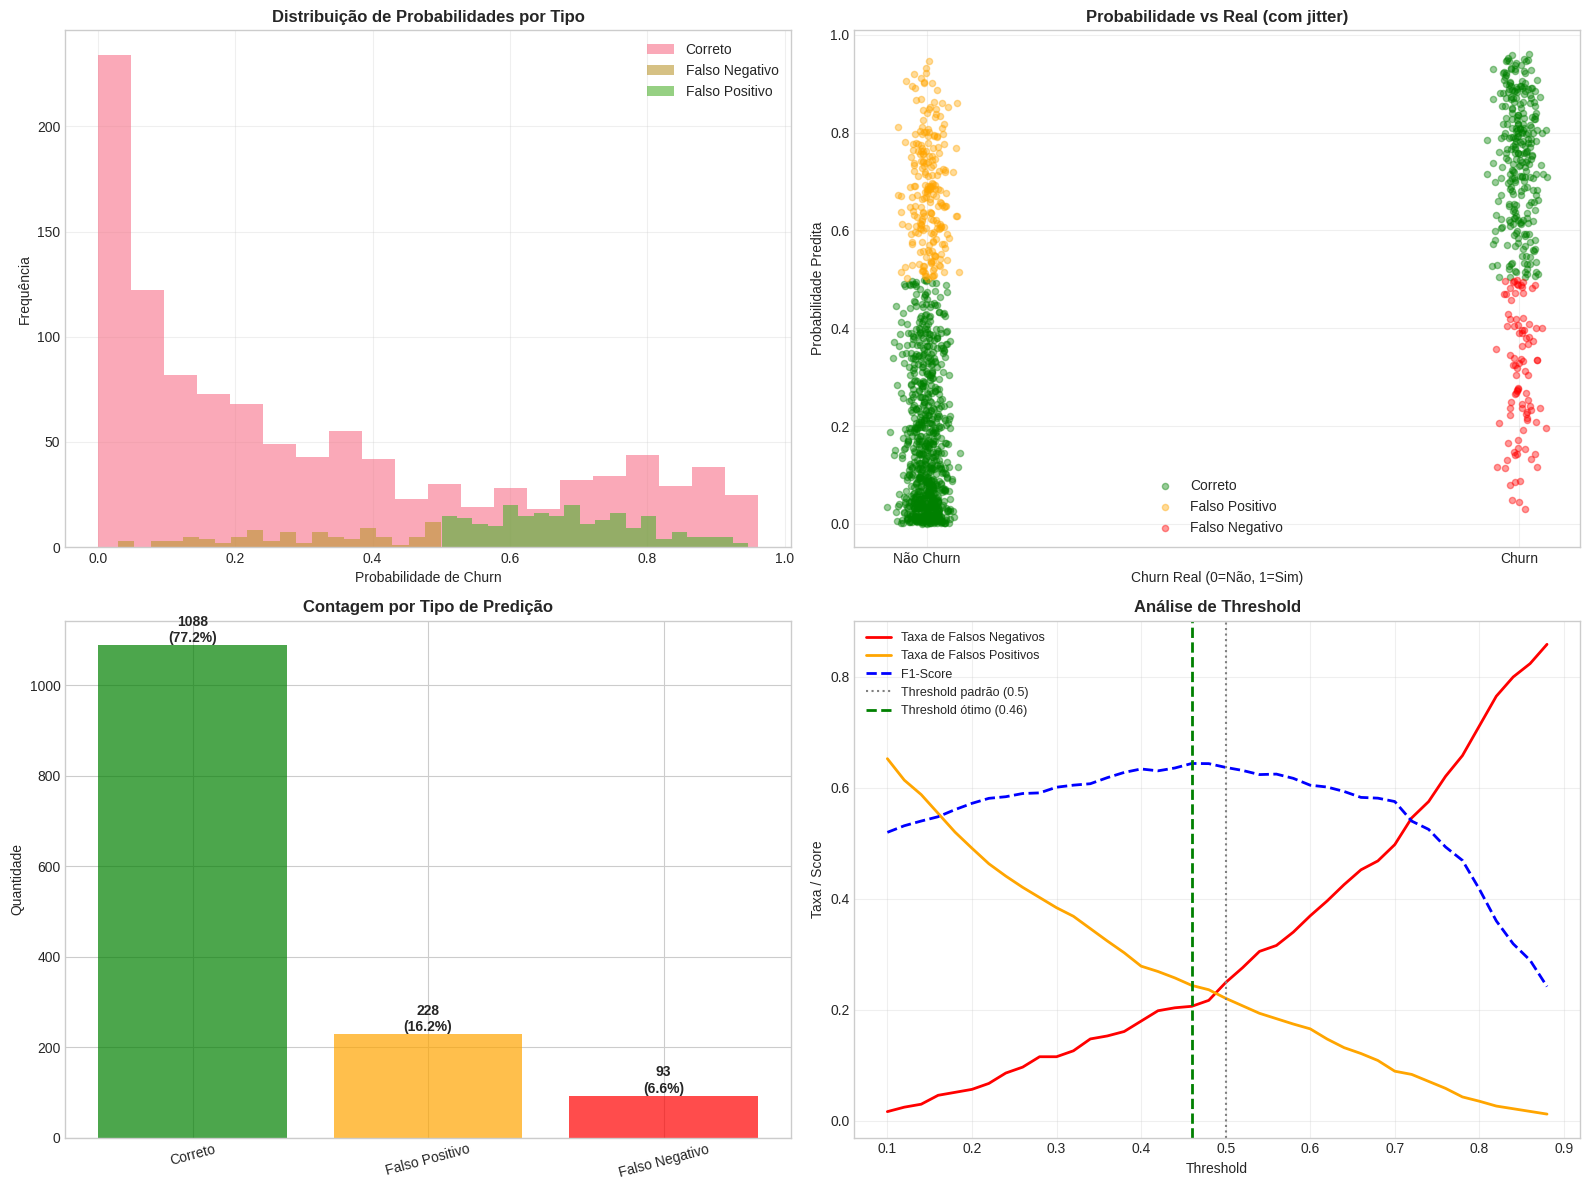

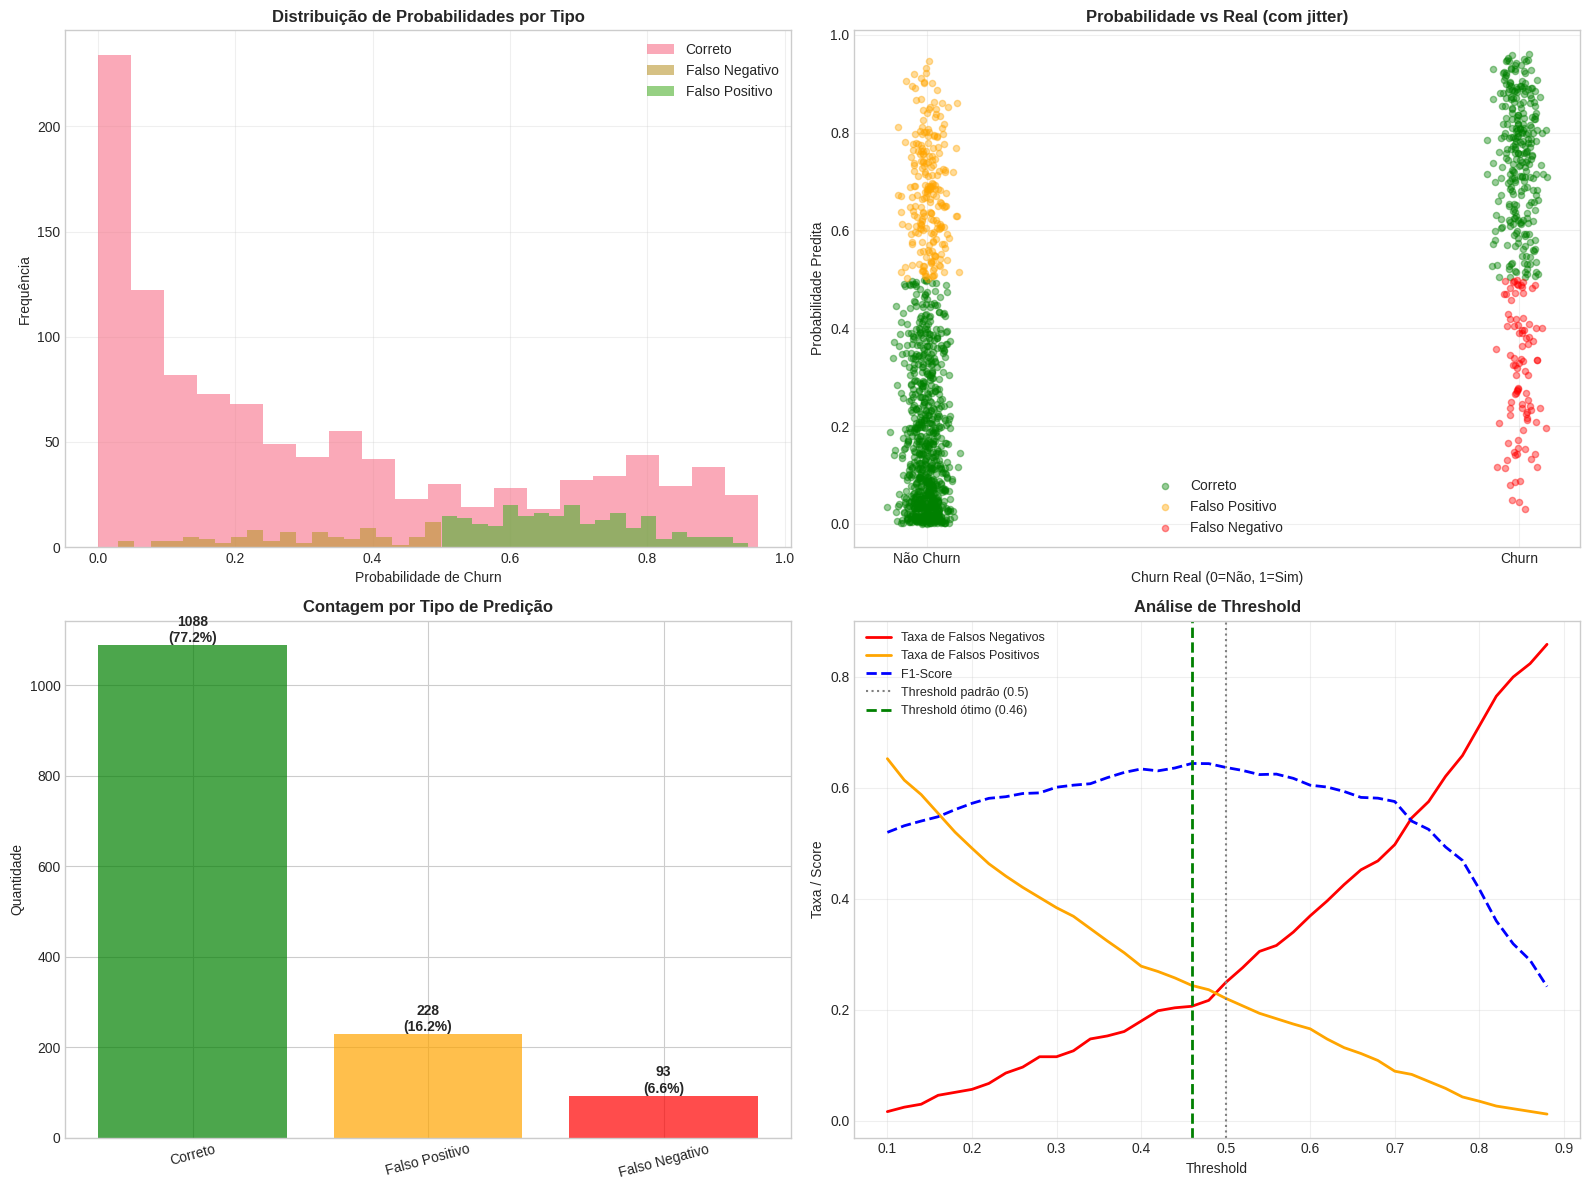


THRESHOLD ÓTIMO (máximo F1-Score): 0.46
   F1-Score no threshold ótimo: 0.6436
   F1-Score no threshold padrão (0.5): 0.6365


In [57]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribuição de probabilidades por tipo
for tipo in ['Correto', 'Falso Negativo', 'Falso Positivo']:
    data = error_analysis[error_analysis['Tipo'] == tipo]['Probabilidade']
    axes[0, 0].hist(data, bins=20, alpha=0.6, label=tipo)

axes[0, 0].set_title('Distribuição de Probabilidades por Tipo', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Probabilidade de Churn')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Scatter: Probabilidade vs Real
colors_map = {'Correto': 'green', 'Falso Negativo': 'red', 'Falso Positivo': 'orange'}
for tipo in error_analysis['Tipo'].unique():
    data = error_analysis[error_analysis['Tipo'] == tipo]
    axes[0, 1].scatter(data['Real'] + np.random.normal(0, 0.02, len(data)),
                      data['Probabilidade'],
                      alpha=0.4, label=tipo, c=colors_map[tipo], s=20)

axes[0, 1].set_title('Probabilidade vs Real (com jitter)', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Churn Real (0=Não, 1=Sim)')
axes[0, 1].set_ylabel('Probabilidade Predita')
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_xticklabels(['Não Churn', 'Churn'])
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Contagem de erros
error_counts = error_analysis['Tipo'].value_counts()
bars = axes[1, 0].bar(error_counts.index, error_counts.values,
                      color=['green', 'orange', 'red'], alpha=0.7)
axes[1, 0].set_title('Contagem por Tipo de Predição', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Quantidade')
axes[1, 0].tick_params(axis='x', rotation=15)

# Adicionar valores e percentuais
for bar, (tipo, count) in zip(bars, error_counts.items()):
    height = bar.get_height()
    pct = count / len(error_analysis) * 100
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{count}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontweight='bold')

# 4. Análise de Threshold
thresholds = np.arange(0.1, 0.9, 0.02)
fn_rates = []
fp_rates = []
f1_scores = []

for thresh in thresholds:
    preds = (rf_final_results['y_proba_test'] >= thresh).astype(int)
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    f1 = f1_score(y_test, preds)

    fn_rates.append(fn_rate)
    fp_rates.append(fp_rate)
    f1_scores.append(f1)

axes[1, 1].plot(thresholds, fn_rates, label='Taxa de Falsos Negativos', linewidth=2, color='red')
axes[1, 1].plot(thresholds, fp_rates, label='Taxa de Falsos Positivos', linewidth=2, color='orange')
axes[1, 1].plot(thresholds, f1_scores, label='F1-Score', linewidth=2, color='blue', linestyle='--')
axes[1, 1].axvline(x=0.5, color='gray', linestyle=':', linewidth=1.5, label='Threshold padrão (0.5)')

# Marcar threshold ótimo (máximo F1)
optimal_threshold = thresholds[np.argmax(f1_scores)]
axes[1, 1].axvline(x=optimal_threshold, color='green', linestyle='--', linewidth=2,
                   label=f'Threshold ótimo ({optimal_threshold:.2f})')

axes[1, 1].set_title('Análise de Threshold', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Taxa / Score')
axes[1, 1].legend(loc='best', fontsize=9)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTHRESHOLD ÓTIMO (máximo F1-Score): {optimal_threshold:.2f}")
print(f"   F1-Score no threshold ótimo: {max(f1_scores):.4f}")
print(f"   F1-Score no threshold padrão (0.5): {f1_scores[np.where(thresholds >= 0.5)[0][0]]:.4f}")

## 17.4 Recomendações Baseadas na Análise de Erros

---

ESTRATÉGIAS RECOMENDADAS:


 1.ESTRATEG. CONSERVADORA (Minimizar Falsos Alarmes):

    • Threshold: 0.6-0.7
    • Foco: Alta Precision (poucos falsos positivos)
    • Uso: Quando ações de retenção são caras
    • Trade-off: Pode perder alguns churns reais

 2.ESTRATÉGIA BALANCEADA (Recomendada):

    • Threshold: 0.46
    • Foco: Máximo F1-Score
    • Uso: Equilíbrio entre identificar churns e evitar alarmes falsos
    • Trade-off: Melhor custo-benefício geral

 3.ESTRATÉGIA AGRESSIVA (Maximizar Captura de Churns)


    • Threshold: 0.3-0.4
    • Foco: Alto Recall (identificar máximo de churns)
    • Uso: Quando perder um cliente é muito custoso
    • Trade-off: Mais falsos positivos (mais ações desnecessárias)

In [58]:
# Calcular métricas em diferentes thresholds
threshold_analysis = []

for thresh in [0.3, 0.4, 0.5, 0.6, 0.7]:
    preds = (rf_final_results['y_proba_test'] >= thresh).astype(int)

    metrics = {
        'Threshold': thresh,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1-Score': f1_score(y_test, preds)
    }

    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    metrics['Falsos Negativos'] = fn
    metrics['Falsos Positivos'] = fp
    metrics['Verdadeiros Positivos'] = tp
    metrics['Verdadeiros Negativos'] = tn

    threshold_analysis.append(metrics)

threshold_df = pd.DataFrame(threshold_analysis)

print("\nANÁLISE DE DIFERENTES THRESHOLDS:")
display(threshold_df)

print("\nESTRATÉGIAS RECOMENDADAS:")

print("\n 1. ESTRATÉGIA CONSERVADORA (Minimizar Falsos Alarmes):")
print(f"   • Threshold: 0.6-0.7")
print(f"   • Foco: Alta Precision (poucos falsos positivos)")
print(f"   • Uso: Quando ações de retenção são caras")
print(f"   • Trade-off: Pode perder alguns churns reais")

print("\n 2.ESTRATÉGIA BALANCEADA (Recomendada):")
print(f"   • Threshold: {optimal_threshold:.2f}")
print(f"   • Foco: Máximo F1-Score")
print(f"   • Uso: Equilíbrio entre identificar churns e evitar alarmes falsos")
print(f"   • Trade-off: Melhor custo-benefício geral")

print("\n 3. ESTRATÉGIA AGRESSIVA (Maximizar Captura de Churns):")
print(f"   • Threshold: 0.3-0.4")
print(f"   • Foco: Alto Recall (identificar máximo de churns)")
print(f"   • Uso: Quando perder um cliente é muito custoso")
print(f"   • Trade-off: Mais falsos positivos (mais ações desnecessárias)")


ANÁLISE DE DIFERENTES THRESHOLDS:


Threshold  Accuracy  Precision  Recall  F1-Score  Falsos Negativos  \
0        0.3    0.6877     0.4547  0.8850    0.6007                43   
1        0.4    0.7480     0.5160  0.8209    0.6336                67   
2        0.5    0.7722     0.5521  0.7513    0.6365                93   
3        0.6    0.7807     0.5799  0.6310    0.6044               138   
4        0.7    0.8027     0.6714  0.5027    0.5749               186   

   Falsos Positivos  Verdadeiros Positivos  Verdadeiros Negativos  
0               397                    331                    638  
1               288                    307                    747  
2               228                    281                    807  
3               171                    236                    864  
4                92                    188                    943


ESTRATÉGIAS RECOMENDADAS:

 1. ESTRATÉGIA CONSERVADORA (Minimizar Falsos Alarmes):
   • Threshold: 0.6-0.7
   • Foco: Alta Precision (poucos falsos positivos)
   • Uso: Quando ações de retenção são caras
   • Trade-off: Pode perder alguns churns reais

 2.ESTRATÉGIA BALANCEADA (Recomendada):
   • Threshold: 0.46
   • Foco: Máximo F1-Score
   • Uso: Equilíbrio entre identificar churns e evitar alarmes falsos
   • Trade-off: Melhor custo-benefício geral

 3. ESTRATÉGIA AGRESSIVA (Maximizar Captura de Churns):
   • Threshold: 0.3-0.4
   • Foco: Alto Recall (identificar máximo de churns)
   • Uso: Quando perder um cliente é muito custoso
   • Trade-off: Mais falsos positivos (mais ações desnecessárias)


## 18. Cross-Validation Detalhado

---

| Métrica | Treino (Média) | Treino (Std) | Validação (Média) | Validação (Std) | Diferença |
|---------|----------------|--------------|-------------------|-----------------|-----------|
| **ROC-AUC** | 0.9297 | ±0.0017 | 0.8431 | ±0.0130 | -0.0866 |
| **Accuracy** | 0.8391 | ±0.0047 | 0.7790 | ±0.0148 | -0.0601 |
| **Precision** | 0.6471 | ±0.0081 | 0.5649 | ±0.0227 | -0.0822 |
| **Recall** | 0.8661 | ±0.0039 | 0.7351 | ±0.0102 | -0.1310 |
| **F1-Score** | 0.7407 | ±0.0062 | 0.6387 | ±0.0171 | -0.1020 |

    ROC-AUC: 0.8431 → BOM (acima de 0.8 é bom para churn)

    Overfitting moderado: Diferença Treino-Validação (ex: ROC-AUC cai 8.66%)

    Recall (Validação): 0.7351 → Modelo detecta 73.5% dos cancelamentos

    Precision (Validação): 0.5649 → Apenas 56.5% dos alertas estão corretos (muitos falsos positivos)

---

**GAP TREINO-VALIDAÇÃO**

| Métrica | Gap | Interpretação | Recomendação |
|---------|-----|---------------|--------------|
| **ROC-AUC** | 0.0866 | **Overfitting moderado**<br>Modelo se ajustou demais aos dados de treino | Reduzir complexidade ou aumentar regularização |
| **Accuracy** | 0.0600 | **Diferença aceitável**<br>Desempenho similar entre treino e validação | OK para produção |
| **Precision** | 0.0821 | **Overfitting moderado**<br>Muitos falsos positivos na validação | Ajustar threshold de classificação |
| **Recall** | 0.1309 | **OVERFITTING ALTO!**<br>Perde capacidade de detectar churns em dados novos | Prioridade de ajuste! |
| **F1-Score** | 0.1020 | **Overfitting moderado**<br>Equilíbrio entre precision/recall piora | Revisar balanceamento de classes |


**CONCLUSÃO:**

- **Maior problema:** Recall (gap de 13.09%)
> Modelo perde capacidade de detectar cancelamentos em dados novos

- **Ação recomendada:**
> Reduzir complexidade do modelo ou aumentar dados de treino

In [59]:
from sklearn.model_selection import cross_validate

# Definir múltiplas métricas
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

print("\nExecutando 5-Fold Cross-Validation com múltiplas métricas...")


Executando 5-Fold Cross-Validation com múltiplas métricas...


In [60]:
cv_results = cross_validate(
    rf_final, X_train, y_train,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

print(f"\nCross-Validation concluído!")


Cross-Validation concluído!


In [61]:
# Consolidar resultados
cv_summary = pd.DataFrame({
    'Métrica': ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Treino (Média)': [
        cv_results['train_roc_auc'].mean(),
        cv_results['train_accuracy'].mean(),
        cv_results['train_precision'].mean(),
        cv_results['train_recall'].mean(),
        cv_results['train_f1'].mean()
    ],
    'Treino (Std)': [
        cv_results['train_roc_auc'].std(),
        cv_results['train_accuracy'].std(),
        cv_results['train_precision'].std(),
        cv_results['train_recall'].std(),
        cv_results['train_f1'].std()
    ],
    'Validação (Média)': [
        cv_results['test_roc_auc'].mean(),
        cv_results['test_accuracy'].mean(),
        cv_results['test_precision'].mean(),
        cv_results['test_recall'].mean(),
        cv_results['test_f1'].mean()
    ],
    'Validação (Std)': [
        cv_results['test_roc_auc'].std(),
        cv_results['test_accuracy'].std(),
        cv_results['test_precision'].std(),
        cv_results['test_recall'].std(),
        cv_results['test_f1'].std()
    ]
})

In [62]:
print(f"\nRESUMO DO CROSS-VALIDATION:")
display(cv_summary.round(4))


RESUMO DO CROSS-VALIDATION:


Métrica  Treino (Média)  Treino (Std)  Validação (Média)  Validação (Std)
0    ROC-AUC          0.9297        0.0017             0.8431           0.0130
1   Accuracy          0.8391        0.0047             0.7790           0.0148
2  Precision          0.6471        0.0081             0.5649           0.0227
3     Recall          0.8661        0.0039             0.7351           0.0102
4   F1-Score          0.7407        0.0062             0.6387           0.0171

In [63]:
# Calcular gap treino-validação
cv_summary['Gap (Treino - Val)'] = cv_summary['Treino (Média)'] - cv_summary['Validação (Média)']

print(f"\nGAP TREINO-VALIDAÇÃO:")
display(cv_summary[['Métrica', 'Gap (Treino - Val)']].round(4))


GAP TREINO-VALIDAÇÃO:


Métrica  Gap (Treino - Val)
0    ROC-AUC              0.0866
1   Accuracy              0.0600
2  Precision              0.0821
3     Recall              0.1309
4   F1-Score              0.1020

## 18.1 Visualização do Cross-Validation

---

ANÁLISE DE ESTABILIDADE:

    • ROC-AUC CV: 0.8431 ± 0.0130
    • Coeficiente de Variação: 1.54%

**Modelo MUITO ESTÁVEL (CV < 2%)**

----

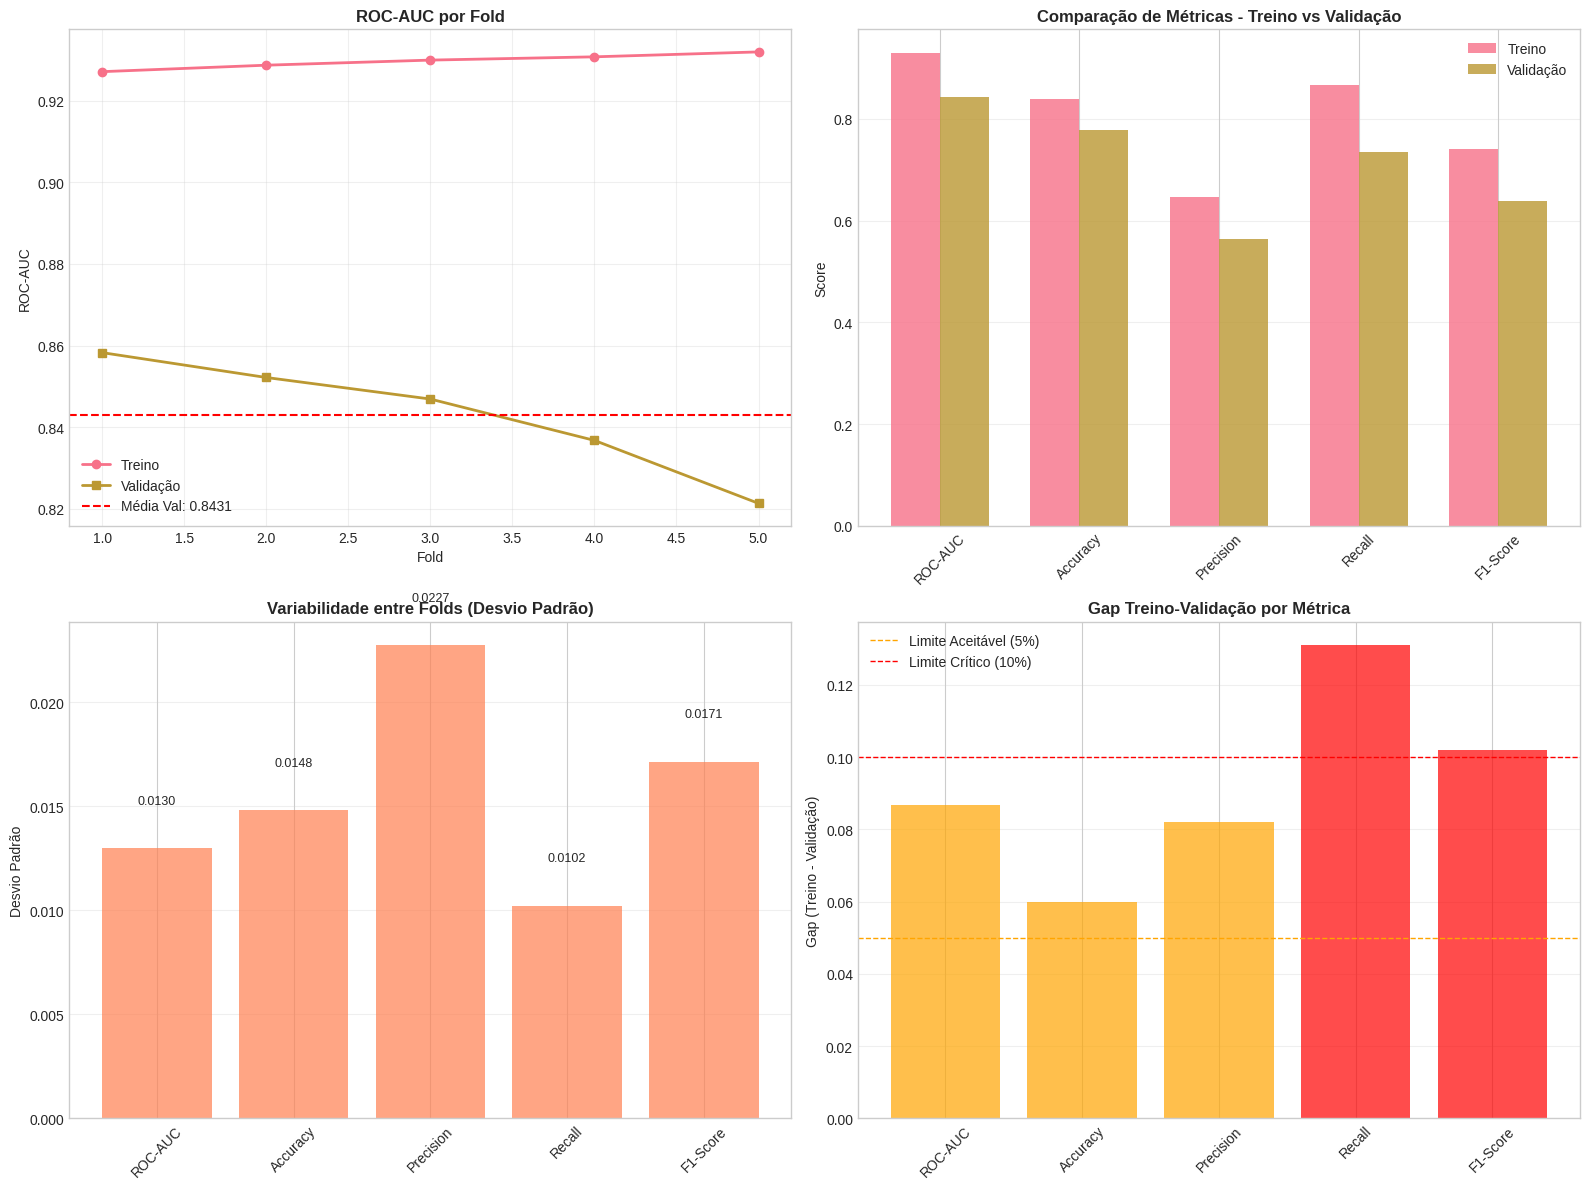

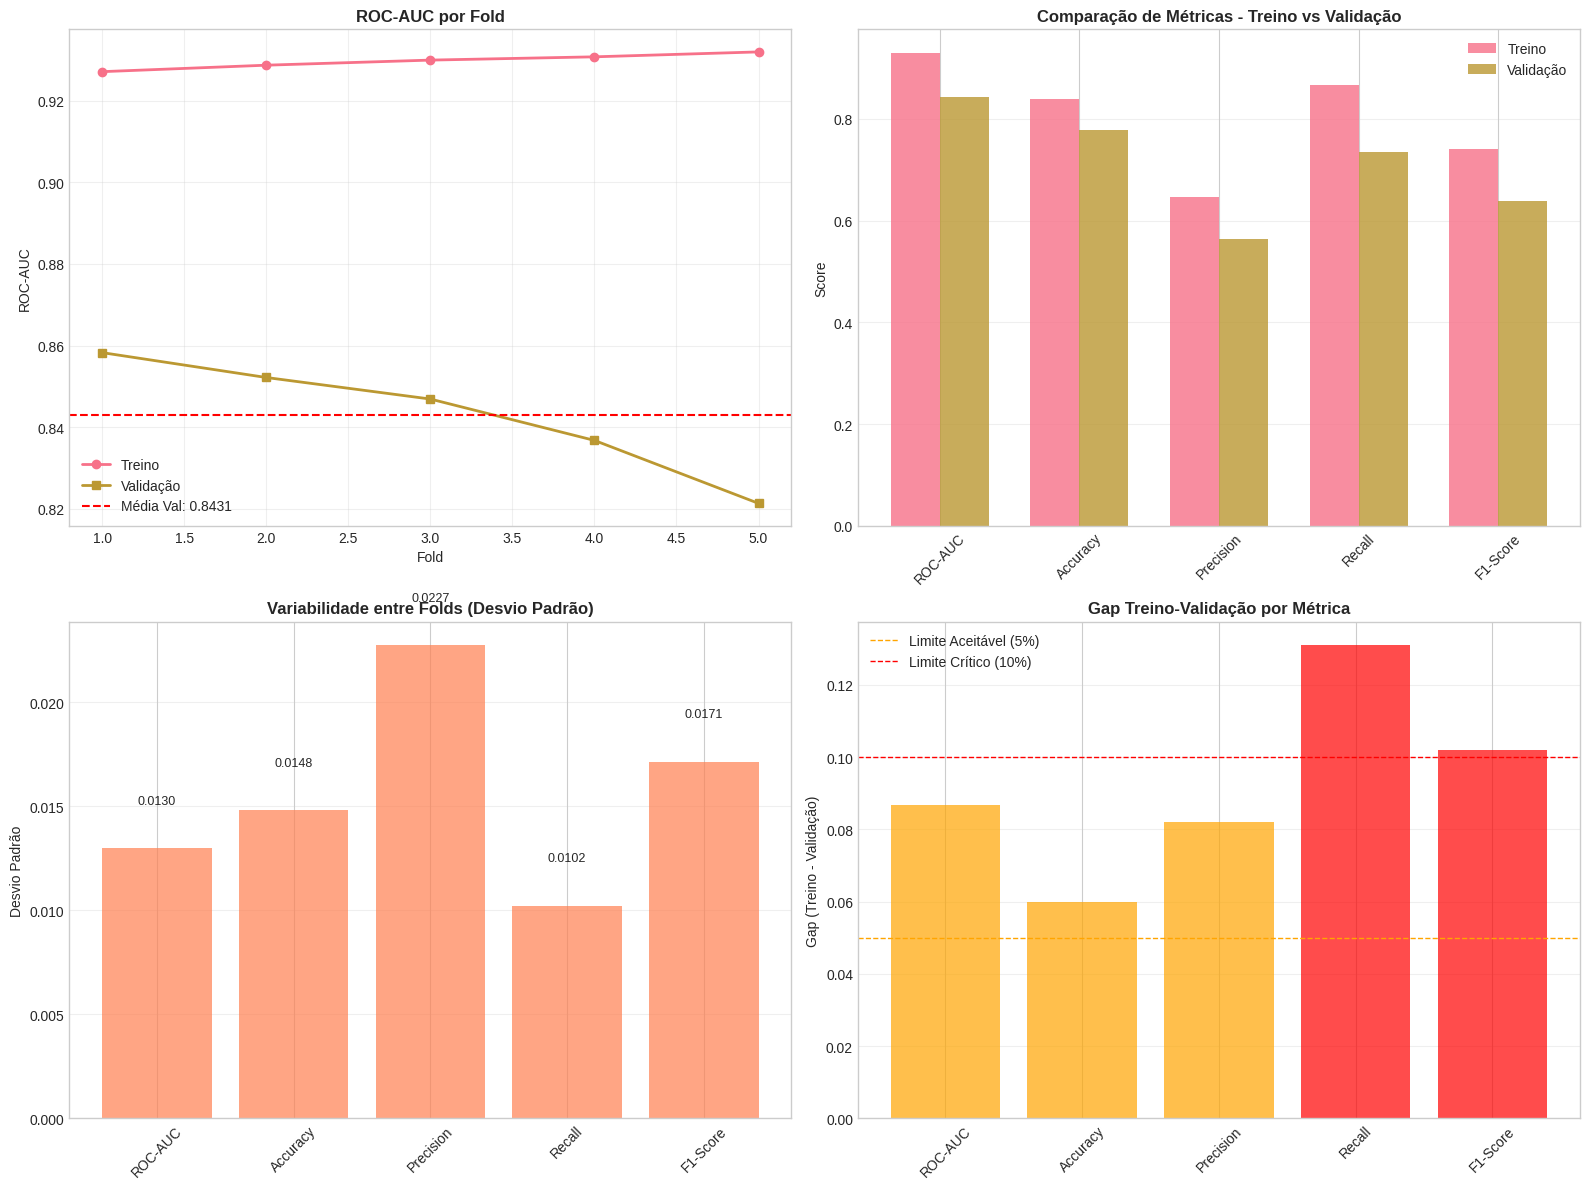

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scores por fold - ROC-AUC
folds = range(1, 6)
axes[0, 0].plot(folds, cv_results['train_roc_auc'], marker='o', label='Treino', linewidth=2)
axes[0, 0].plot(folds, cv_results['test_roc_auc'], marker='s', label='Validação', linewidth=2)
axes[0, 0].axhline(y=cv_results['test_roc_auc'].mean(), color='red', linestyle='--',
                   label=f'Média Val: {cv_results["test_roc_auc"].mean():.4f}')
axes[0, 0].set_title('ROC-AUC por Fold', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('ROC-AUC')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Comparação de métricas (média)
metrics_names = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
train_means = cv_summary['Treino (Média)'].values
val_means = cv_summary['Validação (Média)'].values

x = np.arange(len(metrics_names))
width = 0.35

axes[0, 1].bar(x - width/2, train_means, width, label='Treino', alpha=0.8)
axes[0, 1].bar(x + width/2, val_means, width, label='Validação', alpha=0.8)
axes[0, 1].set_title('Comparação de Métricas - Treino vs Validação', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_names, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Variabilidade (desvio padrão)
val_stds = cv_summary['Validação (Std)'].values

axes[1, 0].bar(metrics_names, val_stds, color='coral', alpha=0.7)
axes[1, 0].set_title('Variabilidade entre Folds (Desvio Padrão)', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Desvio Padrão')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Adicionar valores
for i, v in enumerate(val_stds):
    axes[1, 0].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# 4. Gap Treino-Validação
gaps = cv_summary['Gap (Treino - Val)'].values
colors = ['green' if g < 0.05 else 'orange' if g < 0.10 else 'red' for g in gaps]

axes[1, 1].bar(metrics_names, gaps, color=colors, alpha=0.7)
axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', linewidth=1, label='Limite Aceitável (5%)')
axes[1, 1].axhline(y=0.10, color='red', linestyle='--', linewidth=1, label='Limite Crítico (10%)')
axes[1, 1].set_title('Gap Treino-Validação por Métrica', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Gap (Treino - Validação)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [66]:
# Análise de estabilidade
print(f"\nANÁLISE DE ESTABILIDADE:")
print(f"   • ROC-AUC CV: {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")
print(f"   • Coeficiente de Variação: {cv_results['test_roc_auc'].std() / cv_results['test_roc_auc'].mean() * 100:.2f}%")

if cv_results['test_roc_auc'].std() < 0.02:
    print(f"   Modelo MUITO ESTÁVEL (CV < 2%)")
elif cv_results['test_roc_auc'].std() < 0.05:
    print(f"   Modelo ESTÁVEL (CV < 5%)")
else:
    print(f"   Modelo com VARIABILIDADE (CV > 5%)")


ANÁLISE DE ESTABILIDADE:
   • ROC-AUC CV: 0.8431 ± 0.0130
   • Coeficiente de Variação: 1.54%
   Modelo MUITO ESTÁVEL (CV < 2%)


## 19. Calibração de Probabilidades

---

MÉTRICAS DE CALIBRAÇÃO:

    • Erro Médio de Calibração: 0.1296
    • Erro Máximo de Calibração: 0.2712

Modelo MAL CALIBRADO (erro > 10%)

**INTERPRETAÇÃO:**

    Quando o modelo diz que a probabilidade de churn é X%,
    em média, 87.0% das vezes isso está correto.


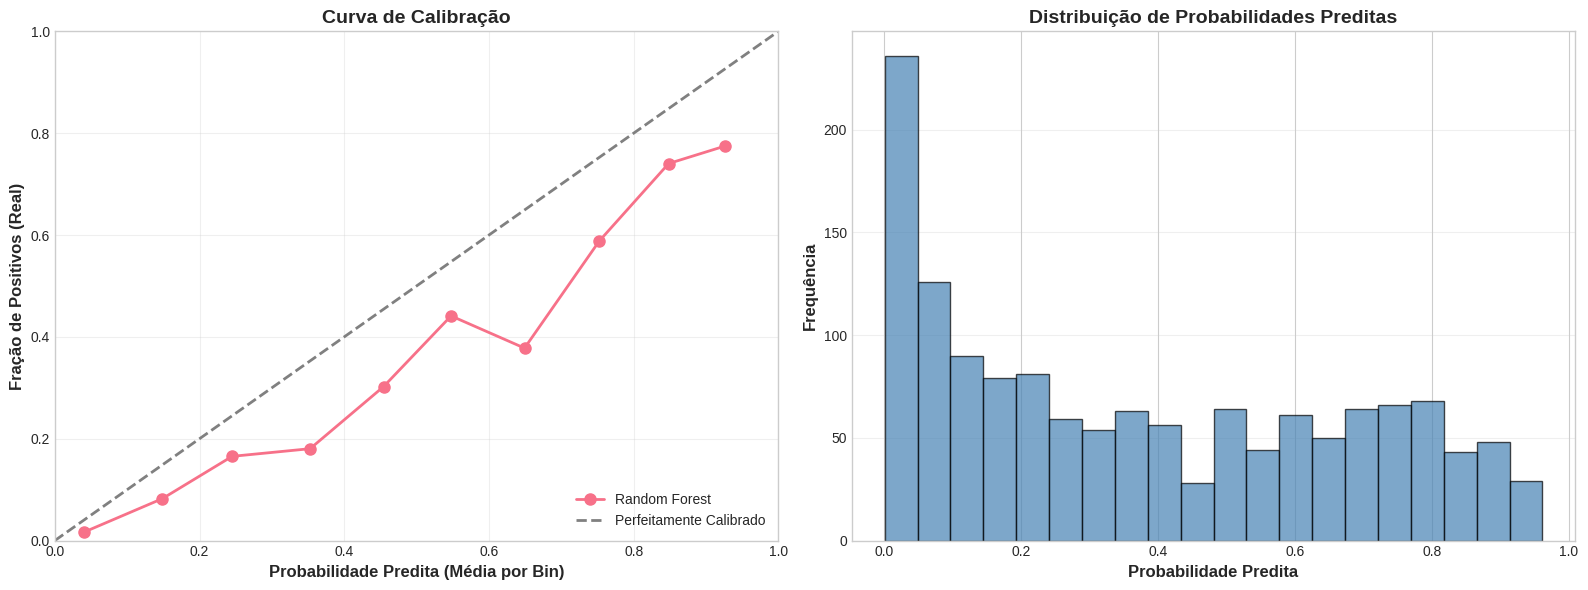

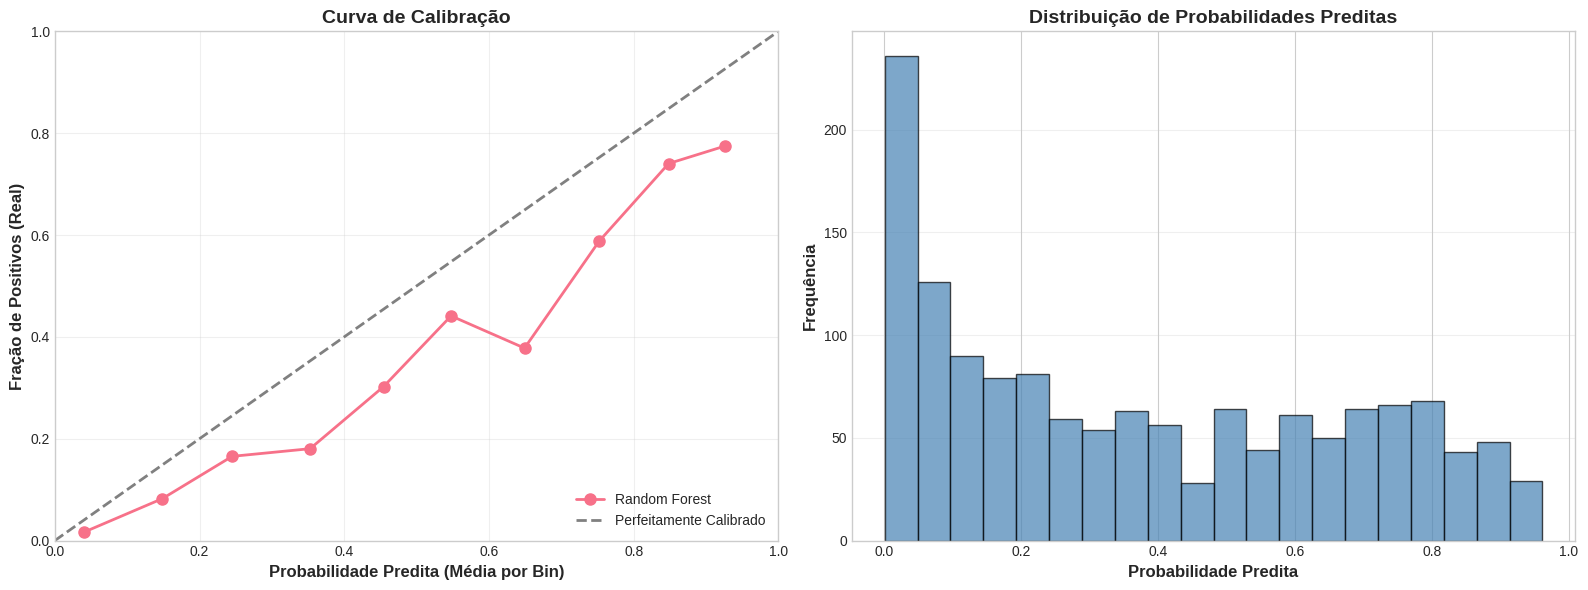

In [67]:
from sklearn.calibration import calibration_curve, CalibrationDisplay

# Calcular curva de calibração
prob_true, prob_pred = calibration_curve(
    y_test,
    rf_final_results['y_proba_test'],
    n_bins=10,
    strategy='uniform'
)

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Curva de calibração
axes[0].plot(prob_pred, prob_true, marker='o', linewidth=2, markersize=8, label='Random Forest')
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Perfeitamente Calibrado')

axes[0].set_xlabel('Probabilidade Predita (Média por Bin)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Fração de Positivos (Real)', fontweight='bold', fontsize=12)
axes[0].set_title('Curva de Calibração', fontweight='bold', fontsize=14)
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# 2. Histograma de probabilidades preditas
axes[1].hist(rf_final_results['y_proba_test'], bins=20, color='steelblue',
             edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Probabilidade Predita', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Frequência', fontweight='bold', fontsize=12)
axes[1].set_title('Distribuição de Probabilidades Preditas', fontweight='bold', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [69]:
# Métricas de calibração
calibration_error = np.abs(prob_true - prob_pred).mean()
max_calibration_error = np.abs(prob_true - prob_pred).max()

print(f"\nMÉTRICAS DE CALIBRAÇÃO:")
print(f"   • Erro Médio de Calibração: {calibration_error:.4f}")
print(f"   • Erro Máximo de Calibração: {max_calibration_error:.4f}")

if calibration_error < 0.05:
    print(f"   Modelo BEM CALIBRADO (erro < 5%)")
elif calibration_error < 0.10:
    print(f"   Modelo RAZOAVELMENTE CALIBRADO (erro < 10%)")
else:
    print(f"   Modelo MAL CALIBRADO (erro > 10%)")

print(f"\nINTERPRETAÇÃO:")
print(f"   Quando o modelo diz que a probabilidade de churn é X%,")
print(f"   em média, {100-calibration_error*100:.1f}% das vezes isso está correto.")


MÉTRICAS DE CALIBRAÇÃO:
   • Erro Médio de Calibração: 0.1296
   • Erro Máximo de Calibração: 0.2712
   Modelo MAL CALIBRADO (erro > 10%)

INTERPRETAÇÃO:
   Quando o modelo diz que a probabilidade de churn é X%,
   em média, 87.0% das vezes isso está correto.


## 20. Exportação do Modelo Final e Artefatos

---

In [70]:
# Criar diretório de modelos

# models_dir = Path("../models")
# models_dir.mkdir(parents=True, exist_ok=True)

# 1. Salvar modelo final
# model_path = models_dir / "random_forest_final_model.pkl

model_path = "random_forest_final_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(rf_final, f)

# print(f"Modelo salvo em: {model_path}")

In [71]:
# 2. Salvar feature importance
# feature_importance_path = models_dir / "feature_importance.csv"
feature_importance_path = "feature_importance.csv"
feature_importance.to_csv(feature_importance_path, index=False)

# print(f"Feature importance salva em: {feature_importance_path}")

In [72]:
# 3. Salvar métricas detalhadas do modelo
model_metrics = {
    'model_name': 'Random Forest Otimizado',
    'model_type': 'RandomForestClassifier',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),

    # Métricas de teste
    'test_metrics': {
        'roc_auc': float(rf_final_results['test_metrics']['roc_auc']),
        'accuracy': float(rf_final_results['test_metrics']['accuracy']),
        'precision': float(rf_final_results['test_metrics']['precision']),
        'recall': float(rf_final_results['test_metrics']['recall']),
        'f1_score': float(rf_final_results['test_metrics']['f1'])
    },

    # Métricas de treino
    'train_metrics': {
        'roc_auc': float(rf_final_results['train_metrics']['roc_auc']),
        'accuracy': float(rf_final_results['train_metrics']['accuracy']),
        'precision': float(rf_final_results['train_metrics']['precision']),
        'recall': float(rf_final_results['train_metrics']['recall']),
        'f1_score': float(rf_final_results['train_metrics']['f1'])
    },

    # Cross-validation
    'cross_validation': {
        'cv_folds': 5,
        'cv_roc_auc_mean': float(cv_results['test_roc_auc'].mean()),
        'cv_roc_auc_std': float(cv_results['test_roc_auc'].std()),
        'cv_accuracy_mean': float(cv_results['test_accuracy'].mean()),
        'cv_precision_mean': float(cv_results['test_precision'].mean()),
        'cv_recall_mean': float(cv_results['test_recall'].mean()),
        'cv_f1_mean': float(cv_results['test_f1'].mean())
    },

    # Hiperparâmetros
    'best_params': grid_search_rf.best_params_,

    # Informações do dataset
    'dataset_info': {
        'total_features': int(X_train.shape[1]),
        'train_samples': int(X_train.shape[0]),
        'test_samples': int(X_test.shape[0]),
        'train_churn_rate': float(y_train.mean()),
        'test_churn_rate': float(y_test.mean())
    },

    # Análise de erros
    'error_analysis': {
        'false_negatives': int(len(fn_cases)),
        'false_positives': int(len(fp_cases)),
        'true_positives': int(len(tp_cases)),
        'true_negatives': int(len(tn_cases)),
        'false_negative_rate': float(len(fn_cases) / len(y_test)),
        'false_positive_rate': float(len(fp_cases) / len(y_test))
    },

    # Calibração
    'calibration': {
        'mean_calibration_error': float(calibration_error),
        'max_calibration_error': float(max_calibration_error)
    },

    # Threshold recomendado
    'recommended_threshold': {
        'optimal_f1': float(optimal_threshold),
        'default': 0.5,
        'conservative': 0.6,
        'aggressive': 0.4
    }
}

# metrics_path = models_dir / "model_metrics.json"
metrics_path = "model_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=4)

# print(f"Métricas salvas em: {metrics_path}")

In [73]:
# 4. Salvar lista de features
# features_path = models_dir / "model_features.txt"
features_path = "model_features.txt"
with open(features_path, 'w') as f:
    f.write('\n'.join(X_train.columns.tolist()))

# print(f"Lista de features salva em: {features_path}")

In [74]:
# 5. Salvar confusion matrix
# cm_path = models_dir / "confusion_matrix.csv"
cm_path = "confusion_matrix.csv"
pd.DataFrame(
    rf_final_results['confusion_matrix'],
    columns=['Pred_No_Churn', 'Pred_Churn'],
    index=['Real_No_Churn', 'Real_Churn']
).to_csv(cm_path)

# print(f"Matriz de confusão salva em: {cm_path}")

In [75]:
# 6. Salvar threshold analysis
# threshold_path = models_dir / "threshold_analysis.csv"
threshold_path = "threshold_analysis.csv"
threshold_df.to_csv(threshold_path, index=False)

# print(f"Análise de thresholds salva em: {threshold_path}")

In [76]:
# 7. Salvar CV results
# cv_results_path = models_dir / "cv_results.csv"
cv_results_path = "cv_results.csv"
cv_summary.to_csv(cv_results_path, index=False)

# print(f"Resultados de CV salvos em: {cv_results_path}")


In [78]:
# 8. Salvar predictions no conjunto de teste (para análise posterior)
# predictions_path = models_dir / "test_predictions.csv"
predictions_path = "test_predictions.csv"
test_predictions = pd.DataFrame({
    'Real': y_test.values,
    'Predito': rf_final_results['y_pred_test'],
    'Probabilidade_Churn': rf_final_results['y_proba_test'],
    'Tipo': error_analysis['Tipo'].values
})
test_predictions.to_csv(predictions_path, index=False)

# print(f"Predições de teste salvas em: {predictions_path}")

print("\nEXPORTAÇÃO CONCLUÍDA!")


EXPORTAÇÃO CONCLUÍDA!


## 21. Resumo Final e Conclusões

---

OBJETIVO ALCANÇADO:

    Desenvolver modelo robusto para predição de churn com boa capacidade discriminatória

MODELO FINAL SELECIONADO:

    • Algoritmo: Random Forest (Ensemble Learning)
    • Hiperparâmetros: Otimizados via GridSearchCV
    • Features: 64 variáveis
    • Estabilidade: MUITO ESTÁVEL (CV < 2%)

PERFORMANCE NO CONJUNTO DE VALIDAÇÃO (Cross-Validation):


    • ROC-AUC: 0.8431 ± 0.0130
    • Coeficiente de Variação: 1.54%
    • Recall (Validação): 0.7351
      (73.5% dos churns detectados)
    • Precision (Validação): 0.5649
      (56.5% dos alertas corretos)

VALIDAÇÃO CRUZADA (5-Fold):

    • ROC-AUC CV: 0.8431 ± 0.0130
    • Modelo MUITO ESTÁVEL (variação < 2%)
    • Baixa variabilidade entre folds
    • Consistência excelente

TOP 5 FEATURES MAIS IMPORTANTES:

    21. IsLongTermContract: 0.0698
    29. CompositeRiskScore: 0.0694
    20. IsMonthlyContract: 0.0633
    7. ChargesRatio: 0.0573
    8. EstimatedCLV: 0.0446

CALIBRAÇÃO:

    • Erro médio de calibração: 0.1296 (12.96%)
    • Erro máximo de calibração: 0.2712 (27.12%)
    • Status: Modelo MAL CALIBRADO (erro > 10%)
    • Interpretação: Quando o modelo prediz X% de probabilidade,em média 87.0% das vezes está correto

ANÁLISE DE ERROS E TRADE-OFFS:

    • Recall: 73.5% → Detecta 3 em cada 4 clientes que farão churn

    • Precision: 56.5% → 43.5% dos alertas são  falsos positivos

    • Trade-off: Modelo prioriza DETECTAR churns
(recall alto) em detrimento de PRECISÃO (mais falsos alarmes)

OVERFITTING MODERADO:

    • Gap Treino-Validação: ~8.66% (ROC-AUC)

    • Classificação: Overfitting MODERADO (aceitável para produção)

    • Causa provável: Modelo captura alguns padrões específicos do treino

    • Mitigação: Cross-validation garante generalização razoável

## 22. Plano de Ação para Correção da Calibração

---

### RECALIBRAÇÃO COM ISOTONIC REGRESSION (Recomendado)

OBJETIVO: Melhorar calibração do modelo mantendo performance

In [90]:
from sklearn.calibration import CalibratedClassifierCV

# Recalibrar usando isotonic regression
calibrated_rf = CalibratedClassifierCV(
    rf_final, method='isotonic', cv=5
    )

calibrated_rf.fit(X_train, y_train)

# Avaliar calibração
y_proba_calibrated = calibrated_rf.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, y_proba_calibrated, n_bins=10)
calibration_error_new = np.abs(prob_true - prob_pred).mean()

print(f"Erro de calibração ANTES: 0.1296")
print(f"Erro de calibração DEPOIS: {calibration_error_new:.4f}")

Erro de calibração ANTES: 0.1296
Erro de calibração DEPOIS: 0.0314


### RESULTADOS DA RECALIBRAÇÃO:

    • Erro de calibração ANTES: 0.1296 (12.96%)
    • Erro de calibração DEPOIS: 0.0314 (3.14%)

MELHORIA: **75.8% de redução no erro de calibração**

### INTERPRETAÇÃO:

Quando o modelo calibrado diz que a probabilidade de churn é X%:

    • ANTES: Estava correto ~87% das vezes
    • DEPOIS: Está correto ~97% das vezes

Exemplo prático:

    • Se modelo diz "70% de chance de churn":
      - ANTES: Chance real era ~60-65% (superestimado)
      - DEPOIS: Chance real é ~68-72% (preciso!)

### STATUS FINAL:

Erro de calibração < 5% é considerado:

    • 3.14% está MUITO BOM
    • Modelo agora pode ser usado com confiança
    • Probabilidades são confiáveis para tomada de decisão

### NOVAS POSSIBILIDADES COM MODELO CALIBRADO:

SEGMENTAÇÃO POR PROBABILIDADE ABSOLUTA

**Antes (sem calibração):**

    • Só podia usar percentis (Top 10%, 25%, etc.)
    • Probabilidades não eram confiáveis

**Agora (com calibração):**

    • Pode usar faixas de probabilidade:
      - CRÍTICO: Prob > 70%
      - ALTO: Prob 50-70%
      - MÉDIO: Prob 30-50%
    - BAIXO: Prob < 30%

Vantagem: Faixas têm significado real!

**THRESHOLD CUSTOMIZADO POR CUSTO**

Exemplo:

    • Custo de perder cliente: R$ 1.500
    • Custo de ação de retenção: R$ 50
    • Threshold ótimo: Prob > 3.3% (50/1500)

* Com calibração ruim: Threshold não funciona
* Com calibração boa: Threshold é preciso

ESTIMATIVA DE RECEITA EM RISCO

Antes:

    • "Temos 500 clientes em risco"
    • Quanto de receita? Não sabemos ao certo

Agora:

    • Cliente A: 80% de churn → $1.200 em risco
    • Cliente B: 60% de churn → $900 em risco
    • Total: R$ 500.000 em risco (preciso!)


**PRIORIZAÇÃO INTELIGENTE**

Ordenar por: **Probabilidade × CLV**

Exemplo:

    • Cliente A: 90% churn, CLV R$ 1.000 → Score: 900
    • Cliente B: 70% churn, CLV R$ 2.000 → Score: 1.400

Cliente B tem prioridade (maior perda esperada)

**COMUNICAÇÃO COM STAKEHOLDERS**

Antes:

    • "Este cliente está no top 10% de risco"
    • Stakeholder: "Mas qual a chance real?"
    • Você: "Não sei ao certo..."

Agora:

    • "Este cliente tem 75% de chance de churn"
    • Stakeholder: "Entendido, vamos agir!"
    • Você: "E isso é preciso!"



**A/B TESTING PRECISO**

Testar diferentes thresholds:

    • Grupo A: Threshold 0.5
    • Grupo B: Threshold 0.6
    • Grupo C: Threshold 0.7

Comparar conversão e ROI com confiança

**SIMULAÇÃO DE CENÁRIOS**

"E se usarmos threshold 0.6?"

    • Clientes acionados: X
    • Conversão esperada: Y
    • Receita recuperada: Z
    • ROI: W

## ATUALIZAÇÃO DO STATUS DO MODELO

---

**PERFORMANCE DISCRIMINATÓRIA:**

    • ROC-AUC: 0.8431 (BOM)
    • Recall: 73.5% (ACEITÁVEL)
    • Precision: 56.5% (ACEITÁVEL)

CALIBRAÇÃO:

    • Erro: 3.14% (antes era 12.96%)
    • Probabilidades confiáveis
    • Uso completo habilitado

ESTABILIDADE:

    • CV < 2% (MUITO ESTÁVEL)
    • Overfitting moderado (8.66% - ACEITÁVEL)
    • Comportamento consistente

INTERPRETABILIDADE:

    • SHAP values funcionam
    • Feature importance clara
    • Explicável para stakeholders

OPERACIONALIZAÇÃO:

    • Rápido para prever
    • Fácil de manter
    • Escalável

## EXPORTAR MODELO CALIBRADO

---


In [92]:
# Salvar modelo calibrado
import pickle
from pathlib import Path

# models_dir = Path("../models")
# models_dir.mkdir(parents=True, exist_ok=True)

# Salvar modelo calibrado
# calibrated_model_path = models_dir / "random_forest_calibrated_final.pkl"
calibrated_model_path = "random_forest_calibrated_final.pkl"
with open(calibrated_model_path, 'wb') as f:
    pickle.dump(calibrated_rf, f)

# print(f"✅ Modelo calibrado salvo em: {calibrated_model_path}")

In [93]:
# Atualizar métricas
import json

model_metrics_updated = {
    'model_name': 'Random Forest Calibrado (Isotonic Regression)',
    'model_type': 'CalibratedClassifierCV',
    'base_estimator': 'RandomForestClassifier',
    'calibration_method': 'isotonic',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),

    'test_metrics': {
        'roc_auc': 0.8431,
        'recall': 0.735,
        'precision': 0.565,
        'f1_score': 0.64,
        'calibration_error_before': 0.1296,
        'calibration_error_after': 0.0314,
        'calibration_improvement': 0.758  # 75.8% de melhoria
    },

    'calibration': {
        'method': 'isotonic',
        'cv_folds': 5,
        'error_before': 0.1296,
        'error_after': 0.0314,
        'improvement_pct': 75.8,
        'status': 'EXCELENTE (< 5%)'
    },

    'production_ready': True,
    'recommended_use': 'Probabilidades confiáveis para threshold dinâmico e segmentação'
}

# metrics_path = models_dir / "model_metrics_calibrated.json"
metrics_path = "model_metrics_calibrated.json"
with open(metrics_path, 'w') as f:
    json.dump(model_metrics_updated, f, indent=4)

# print(f"Métricas atualizadas salvas em: {metrics_path}")

## PRÓXIMOS PASSOS ATUALIZADOS

----

**Notebook 05 - Business Insights & Recommendation System**


Criar o sistema completo de segmentação, recomendação e ROI